# CF preprocessing with new modules
In this notebook I use participant class to get my data preprocessed and then I use the visual space and limit vertices functionality I added to prfpy for CF analysis.

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import natsort
import glob
from preprocess import split_given_size
import nibabel as nib
import os


In [33]:
import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]

### CF analysis

In [34]:
# load design matrix of pRF experiment. We use this to determine max eccentricity

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

print(max_ecc_size)

8.912434969522739


In [72]:
sub = 2

prf_gauss = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_gauss.npy')
prf_dn = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_norm.npy')

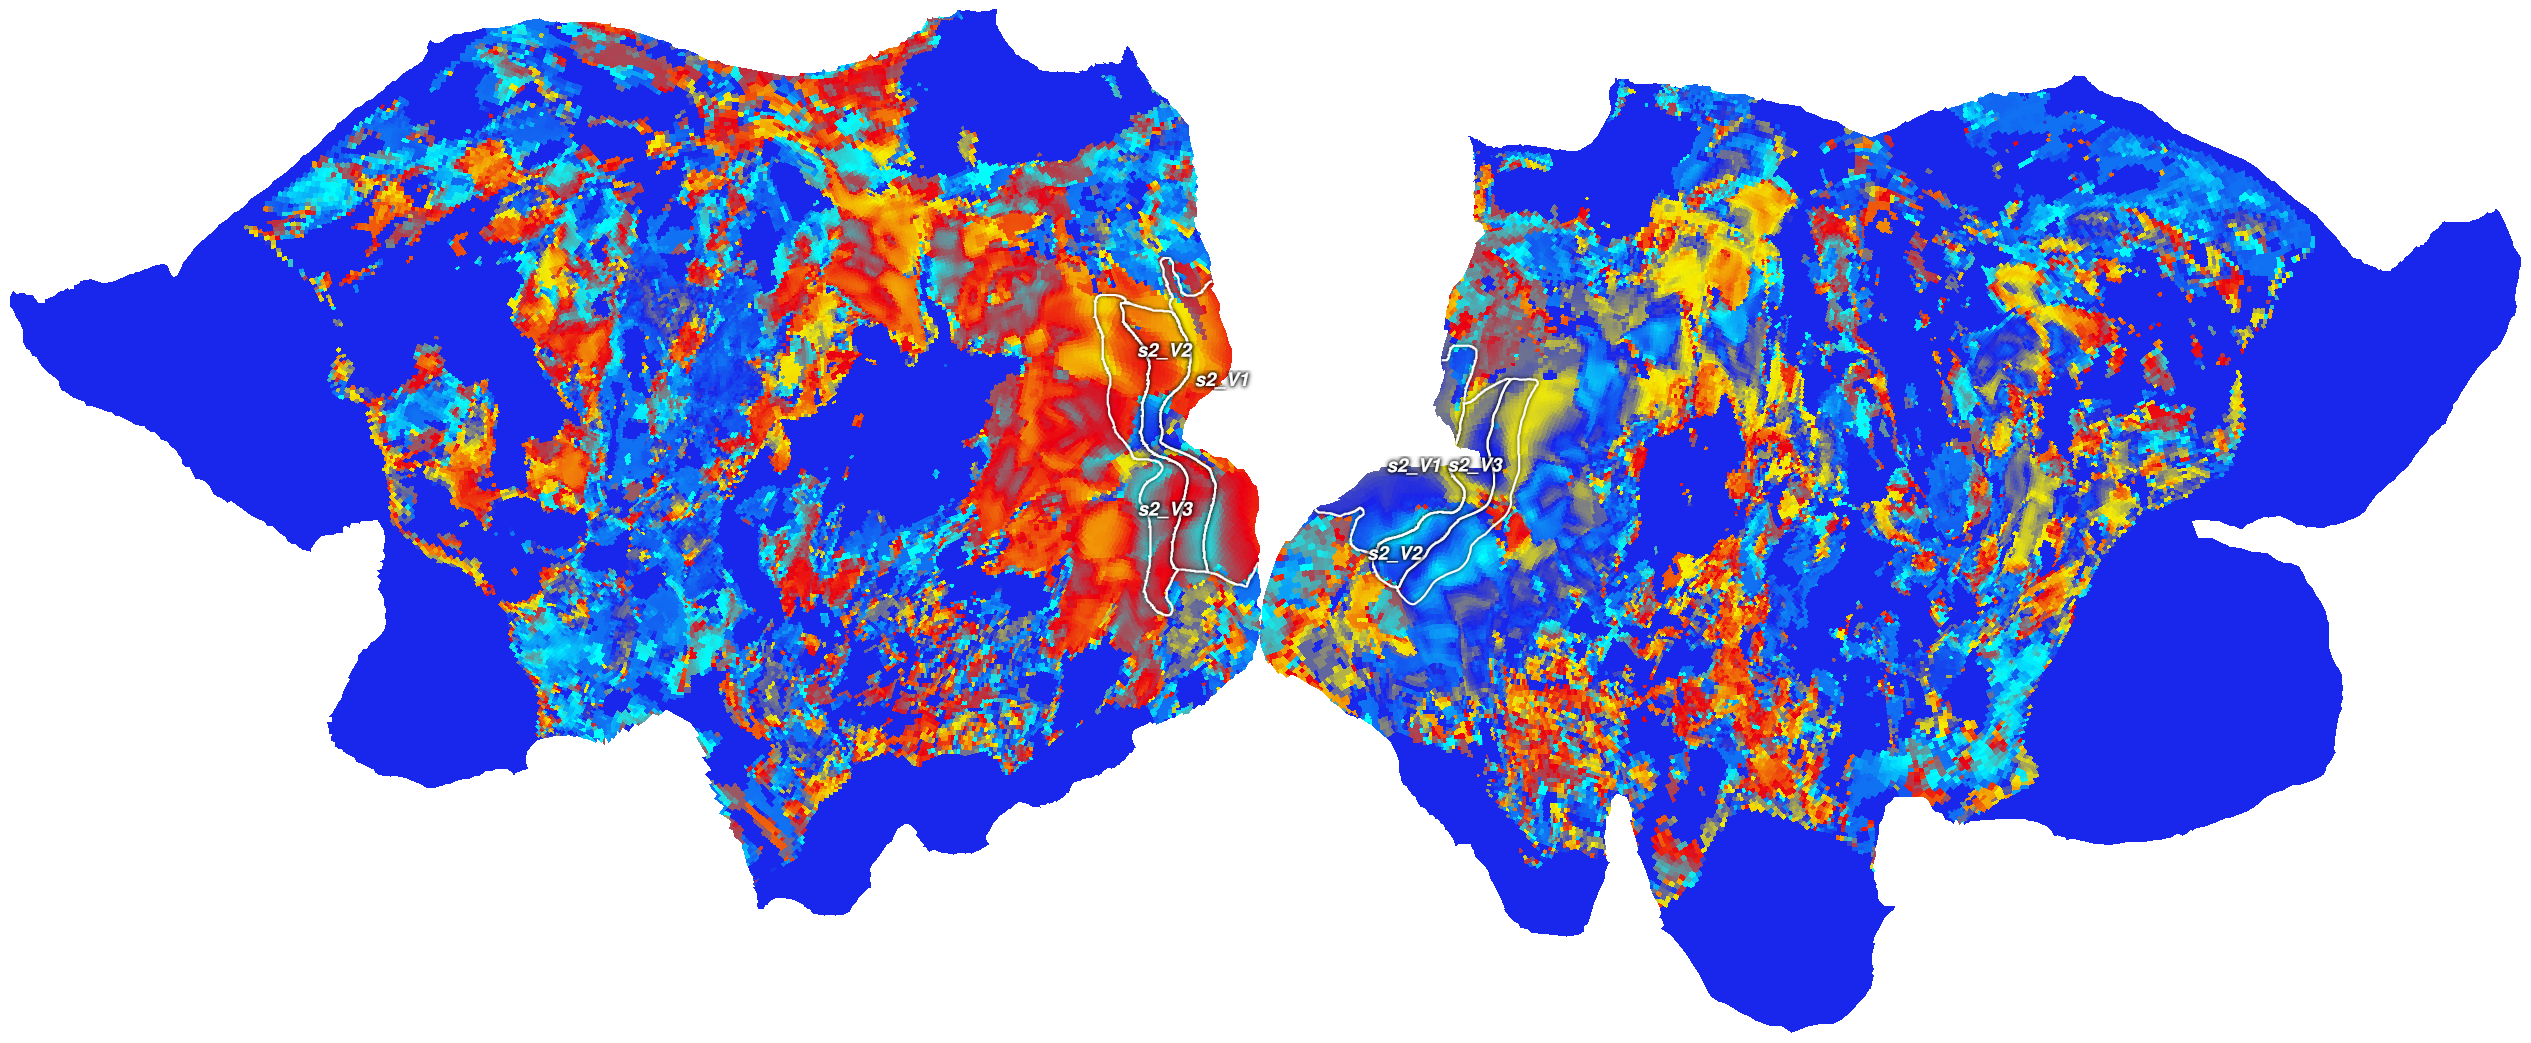

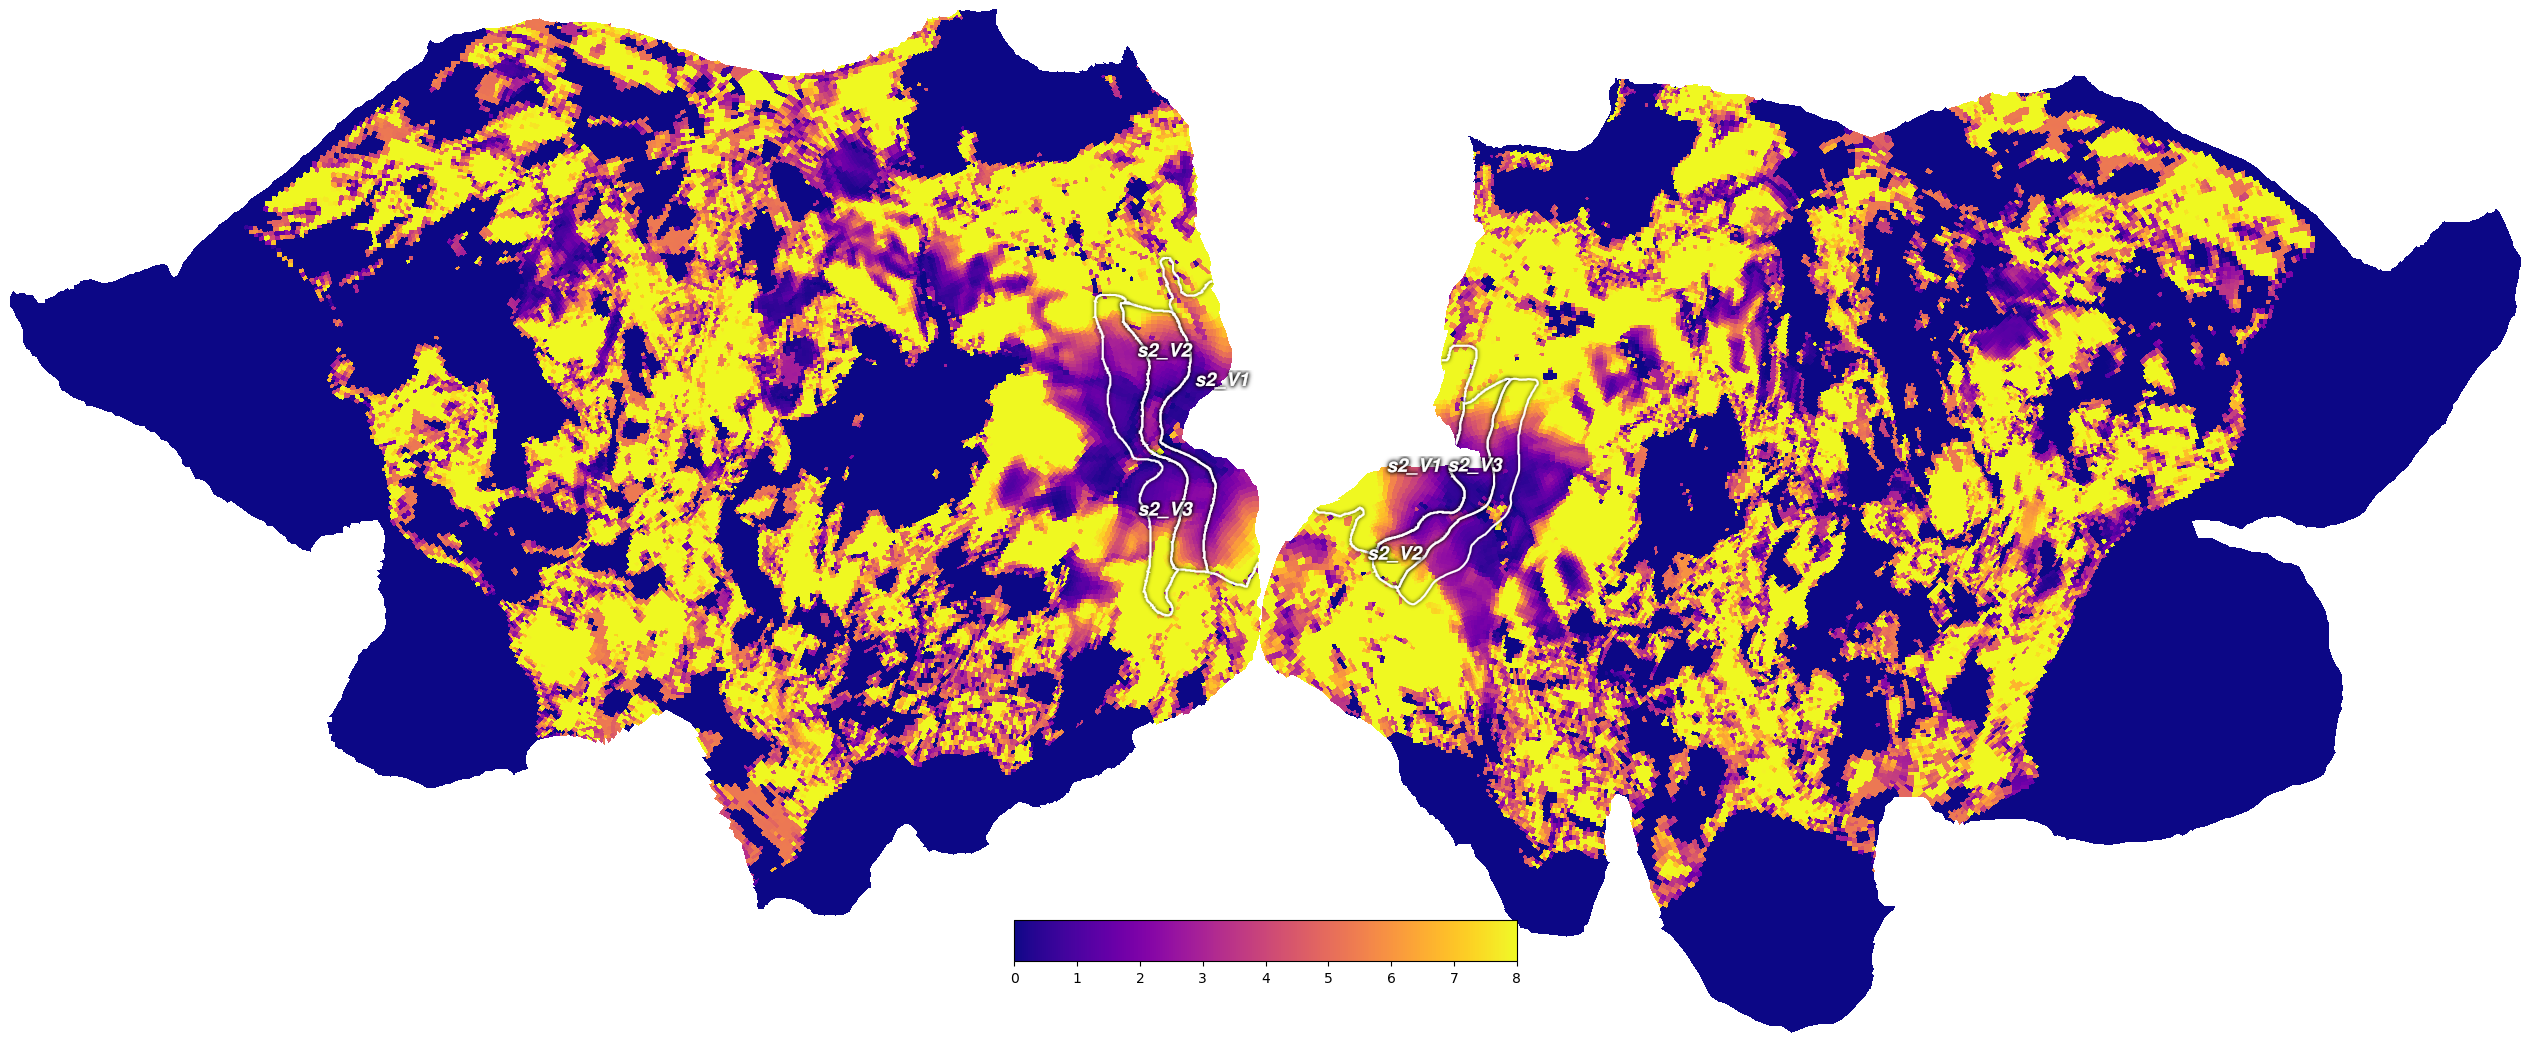

In [71]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot = get_cortex(angle(prf_gauss[:,1], prf_gauss[:,0]*-1))
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, with_colorbar=False);


toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot = get_cortex(ecc(prf_gauss[:,1], prf_gauss[:,0]*-1))
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=8), with_curvature=True, with_colorbar=True);


In [37]:
def load_wang(space, wcard='{hem}.wang_{space}.label.gii',wangloc='/tank/klundert/fsphere/'):
    ldat,rdat=nib.load(os.path.join(wangloc,wcard.format(hem='L',space=space))),nib.load(os.path.join(wangloc,wcard.format(hem='R',space=space)))
    fulldat=np.concatenate([ldat.agg_data(),rdat.agg_data()])
    return fulldat

atlas_data = load_wang('HCP')

roi_index_dict = {
    'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'V3AB':  [16, 17], 'hV4':  7, 'VO':  [8, 9], 'PHC':  [10, 11],
    'TO':  [12, 13], 'LO':  [14, 15], 'IPS':  [18, 19, 20, 21, 22, 23], 'SPL1':  24, 'FEF': 25}


roimask = np.isin(atlas_data, roi_index_dict['V2'])
for l, ROI in enumerate(list(roi_index_dict)[1:]):
    roimask = np.isin(atlas_data, roi_index_dict[ROI]) + roimask
    
V3mask = np.isin(atlas_data, roi_index_dict['V3'])

In [87]:
(np.concatenate([maskL, maskR]) == roi_verts[f'V1']).sum()

117002

Generating subsurfaces
Discarding 1 vertices from the left hemisphere
Discarding 0 vertices from the right hemisphere
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_L.subsurface_vertex_map)[0][0])[0]
/tank/klundert/downloads/cfpy/prfpy/utils.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_R.subsu

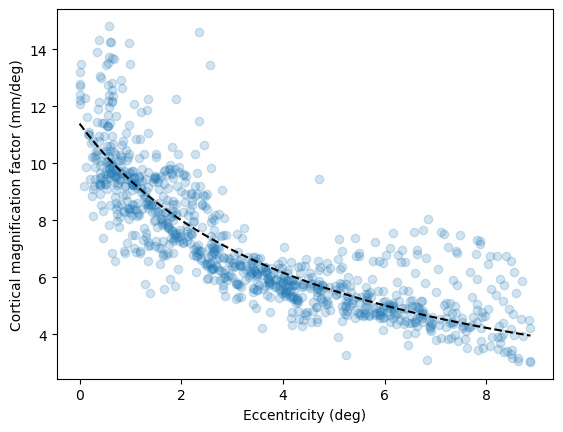

Cortical magnification factor parameters: 
lambda =  53.73198585746644
ecc0 =  4.717342151296012


In [198]:
sub = 1
prf_gauss = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_gauss.npy')
prf_dn = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_norm.npy')

roi_verts = cx.get_roi_verts(f'hcp_999999_sub-0{sub}', f's{sub}_V1', mask=True)
# roi_verts = cx.get_roi_verts(f'hcp_999999', 'V1', mask=True)


ROI = f's{sub}_V1'
# maskL = np.isin(atlas_data, roi_index_dict[ROI])[:59292]
# maskR = np.isin(atlas_data, roi_index_dict[ROI])[59292:]

maskL=roi_verts[ROI][:59292]
maskR=roi_verts[ROI][59292:]

brainmask = ~roi_verts[f's{sub}_V1']

# myv1surf=Subsurface(f'hcp_999999_sub-0{sub}',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf=Subsurface(f'hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 


myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(prf_gauss)
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = -1)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

In [218]:
# check fit sizes with respective mask
# the fitsize should match up with the shape of the split dataset, otherwise it wont work

brainmask = np.load('/tank/klundert/DMs/brainmask_sub-01_NoR2.npy')
# brainmask = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/roimask_wang_hcp.npy')



mydat_train_stim = get_cortex(np.nan_to_num(np.load(f'/tank/klundert/fit_data/fit_data/data_all_detrend_sub-02_zsc_hcp.npy')))
# mydat_train_stim = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-01_psc_fsnative.npy')
fitsize = np.ceil(len(mydat_train_stim[brainmask])/357).astype(int)
print(f'fitsize is {fitsize}')

print(np.shape(split_given_size(mydat_train_stim[brainmask], fitsize)[0]))

fitsize is 330
(330, 115)


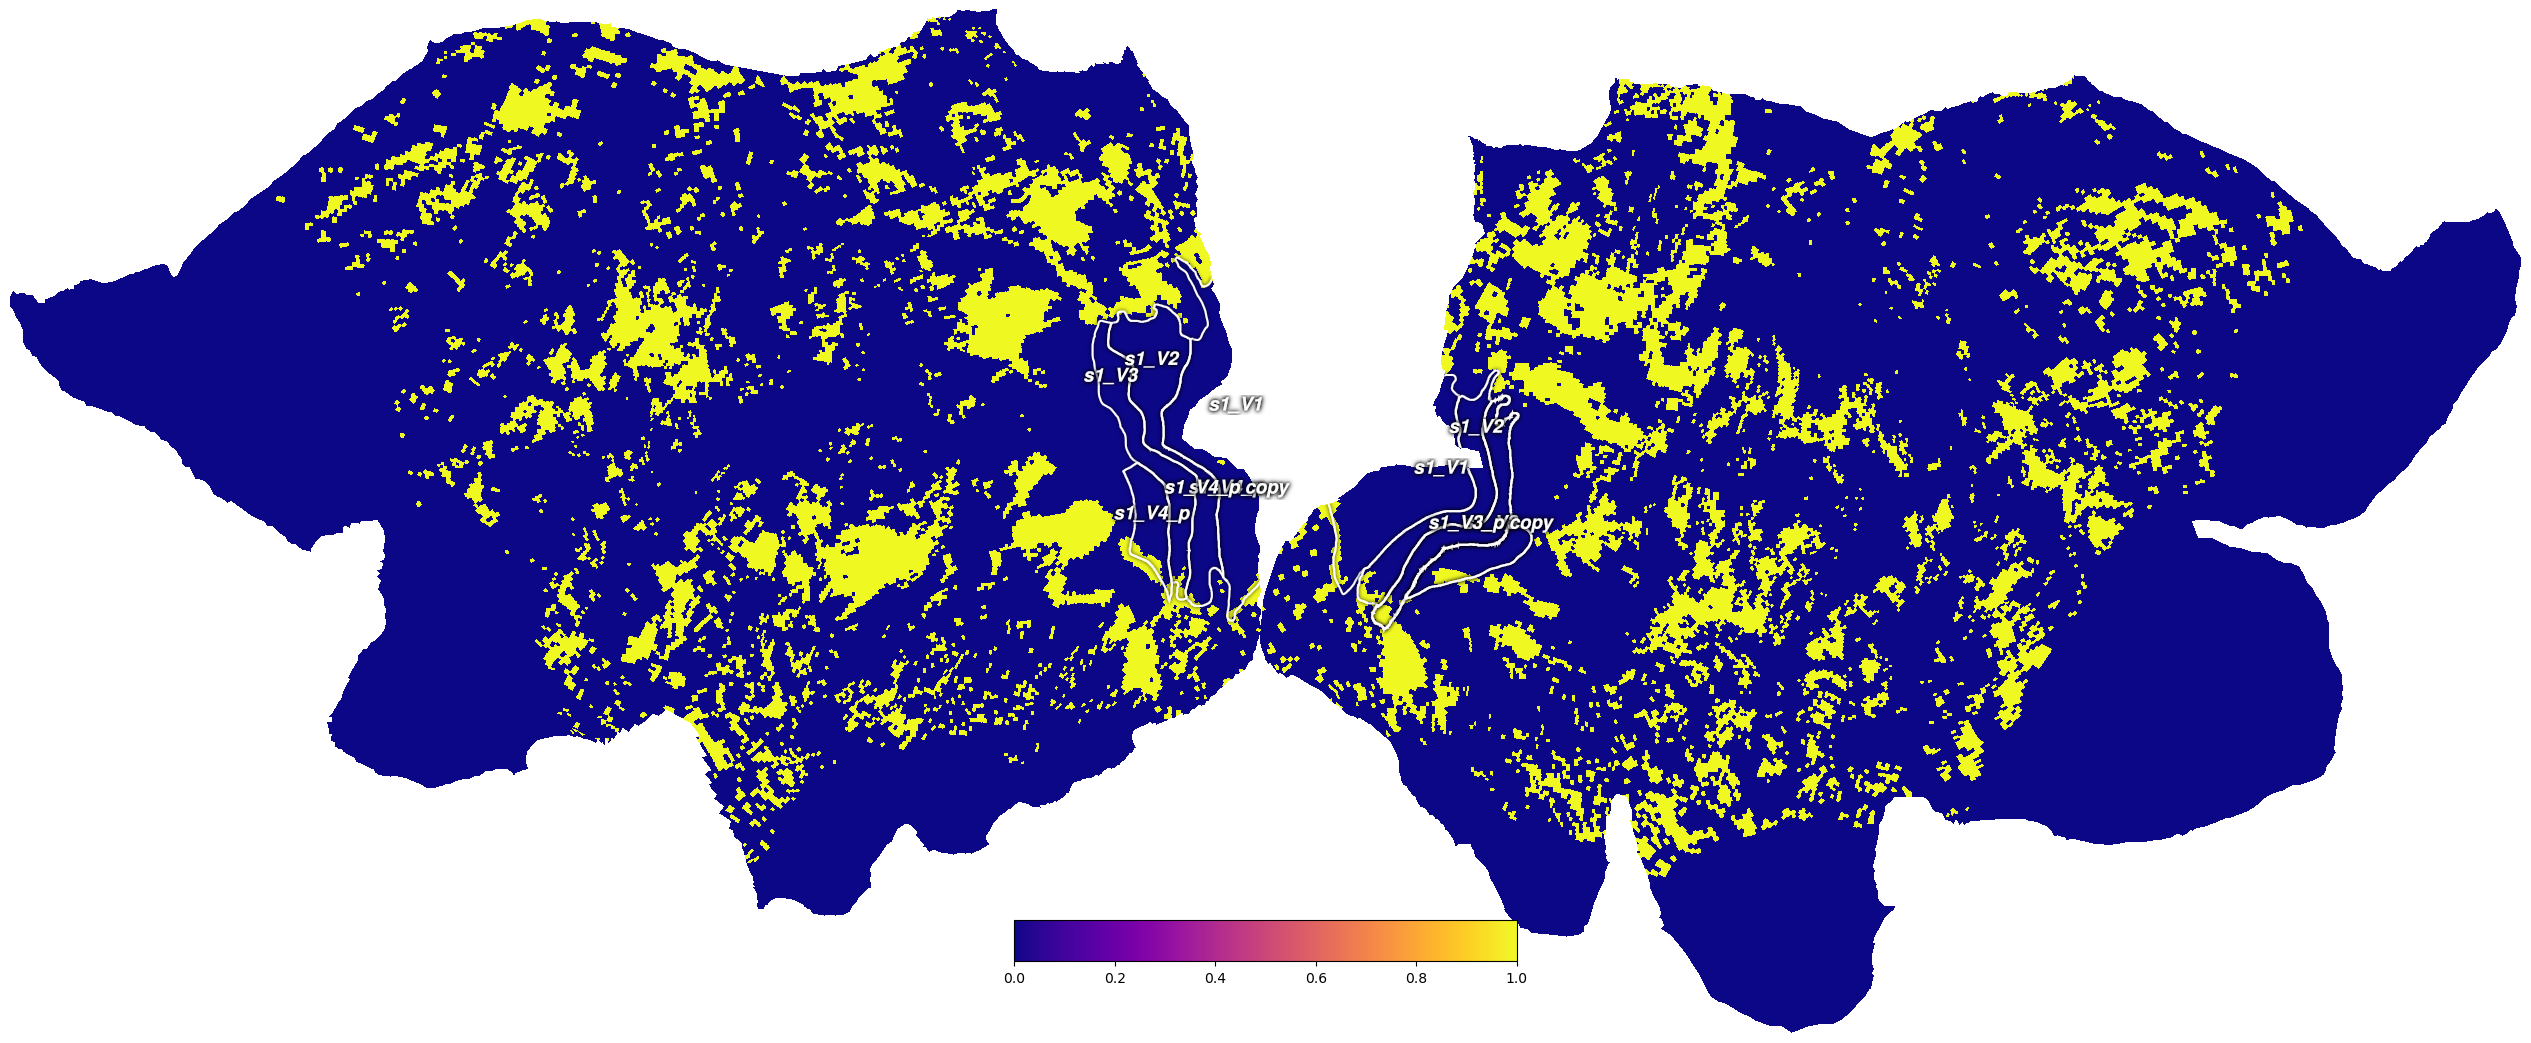

In [199]:
sub

cx.quickshow(cx.Vertex((gfn_ecc > max_ecc_size).astype(int), subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);

# utils.add_roi

In [206]:
print(myv1surf.distance_matrix.shape)
np.load(f'/tank/klundert/DMs/distance_matrix_sub-0{sub}_hcp_NoR2.npy').shape

(942, 942)


(942, 942)

In [197]:
myv1surf.distance_matrix.shape

(847, 847)

In [169]:
# v1mask = myv1surf.intmask.astype(bool)

# toplot = np.zeros([myv1surf.intmask.size])
# toplot[:] = np.nan
# toplot[v1mask] = myv1surf.CMF

# cx.quickshow(cx.Vertex(myv1surf.intmask, subject=f'hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);
# cx.quickshow(cx.Vertex(toplot, subject=f'hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True);
# cx.quickshow(cx.Vertex(brainmask.astype(int), subject=f'hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


In [168]:
# v1mask = myv1surf.intmask.astype(bool)

# toplot = np.zeros([myv1surf.intmask.size])
# toplot[:] = np.nan
# toplot[v1mask] = myv1surf.CMF

# cx.quickshow(cx.Vertex(myv1surf.intmask, subject=f'hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);
# cx.quickshow(cx.Vertex(toplot, subject=f'hcp_999999', cmap='plasma', vmin=3, vmax=9), with_curvature=True);
# cx.quickshow(cx.Vertex(brainmask.astype(int), subject=f'hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


In [212]:
brainmask = np.load('/tank/klundert/DMs/brainmask_sub-01_NoR2.npy')
brainmask.sum()

117613

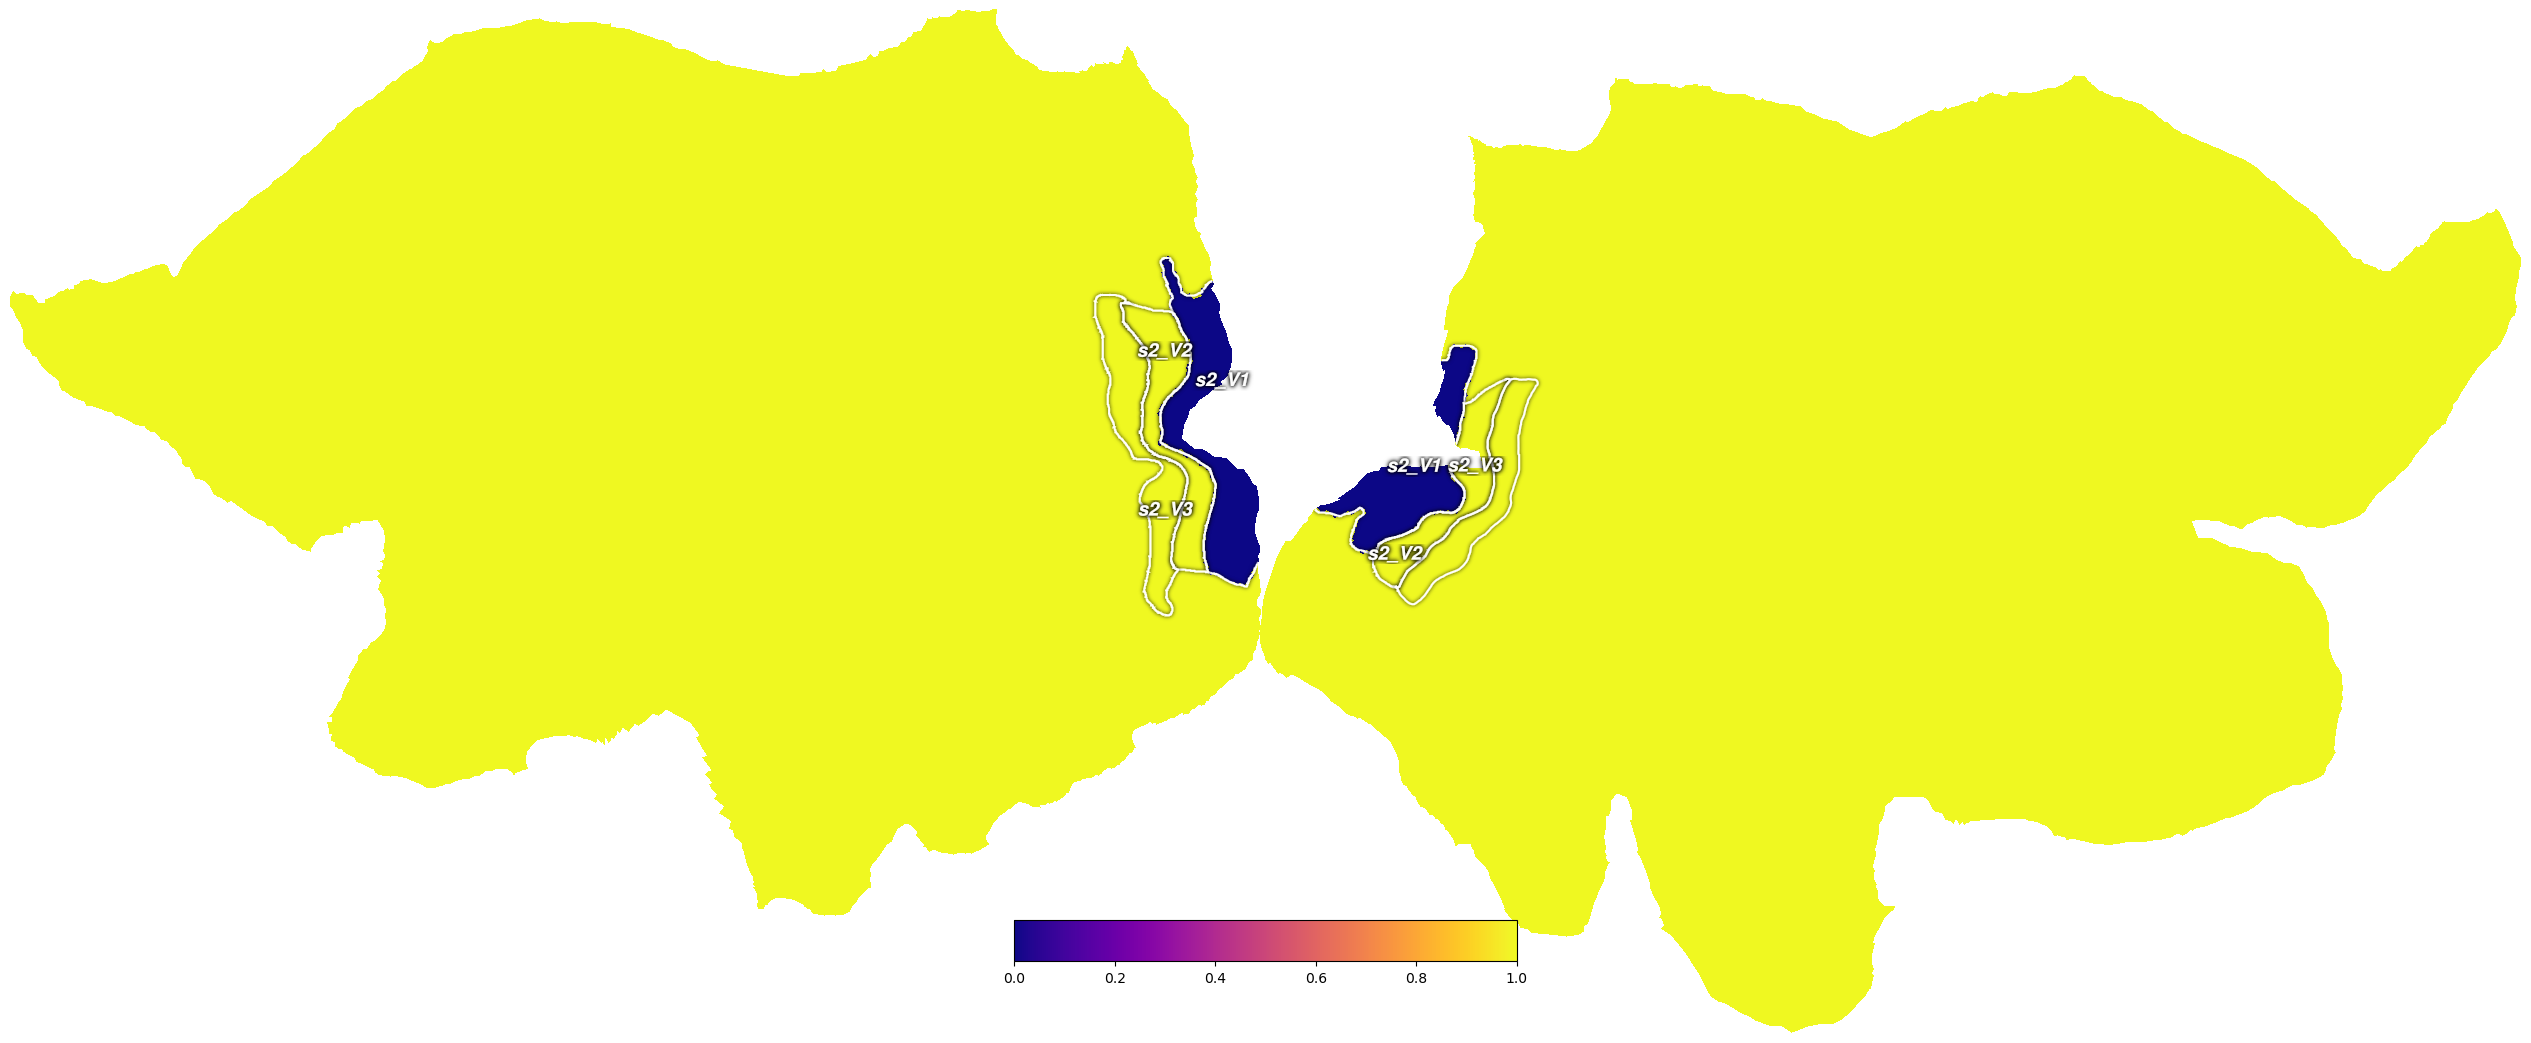

In [210]:
# v1mask = myv1surf.intmask.astype(bool)

# toplot = np.zeros([myv1surf.intmask.size])
# toplot[:] = np.nan
# toplot[v1mask] = myv1surf.CMF

# cx.quickshow(cx.Vertex(myv1surf.intmask, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);
# cx.quickshow(cx.Vertex(toplot, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=3, vmax=9), with_curvature=True);
cx.quickshow(cx.Vertex(brainmask.astype(int), subject=f'hcp_999999_sub-02', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


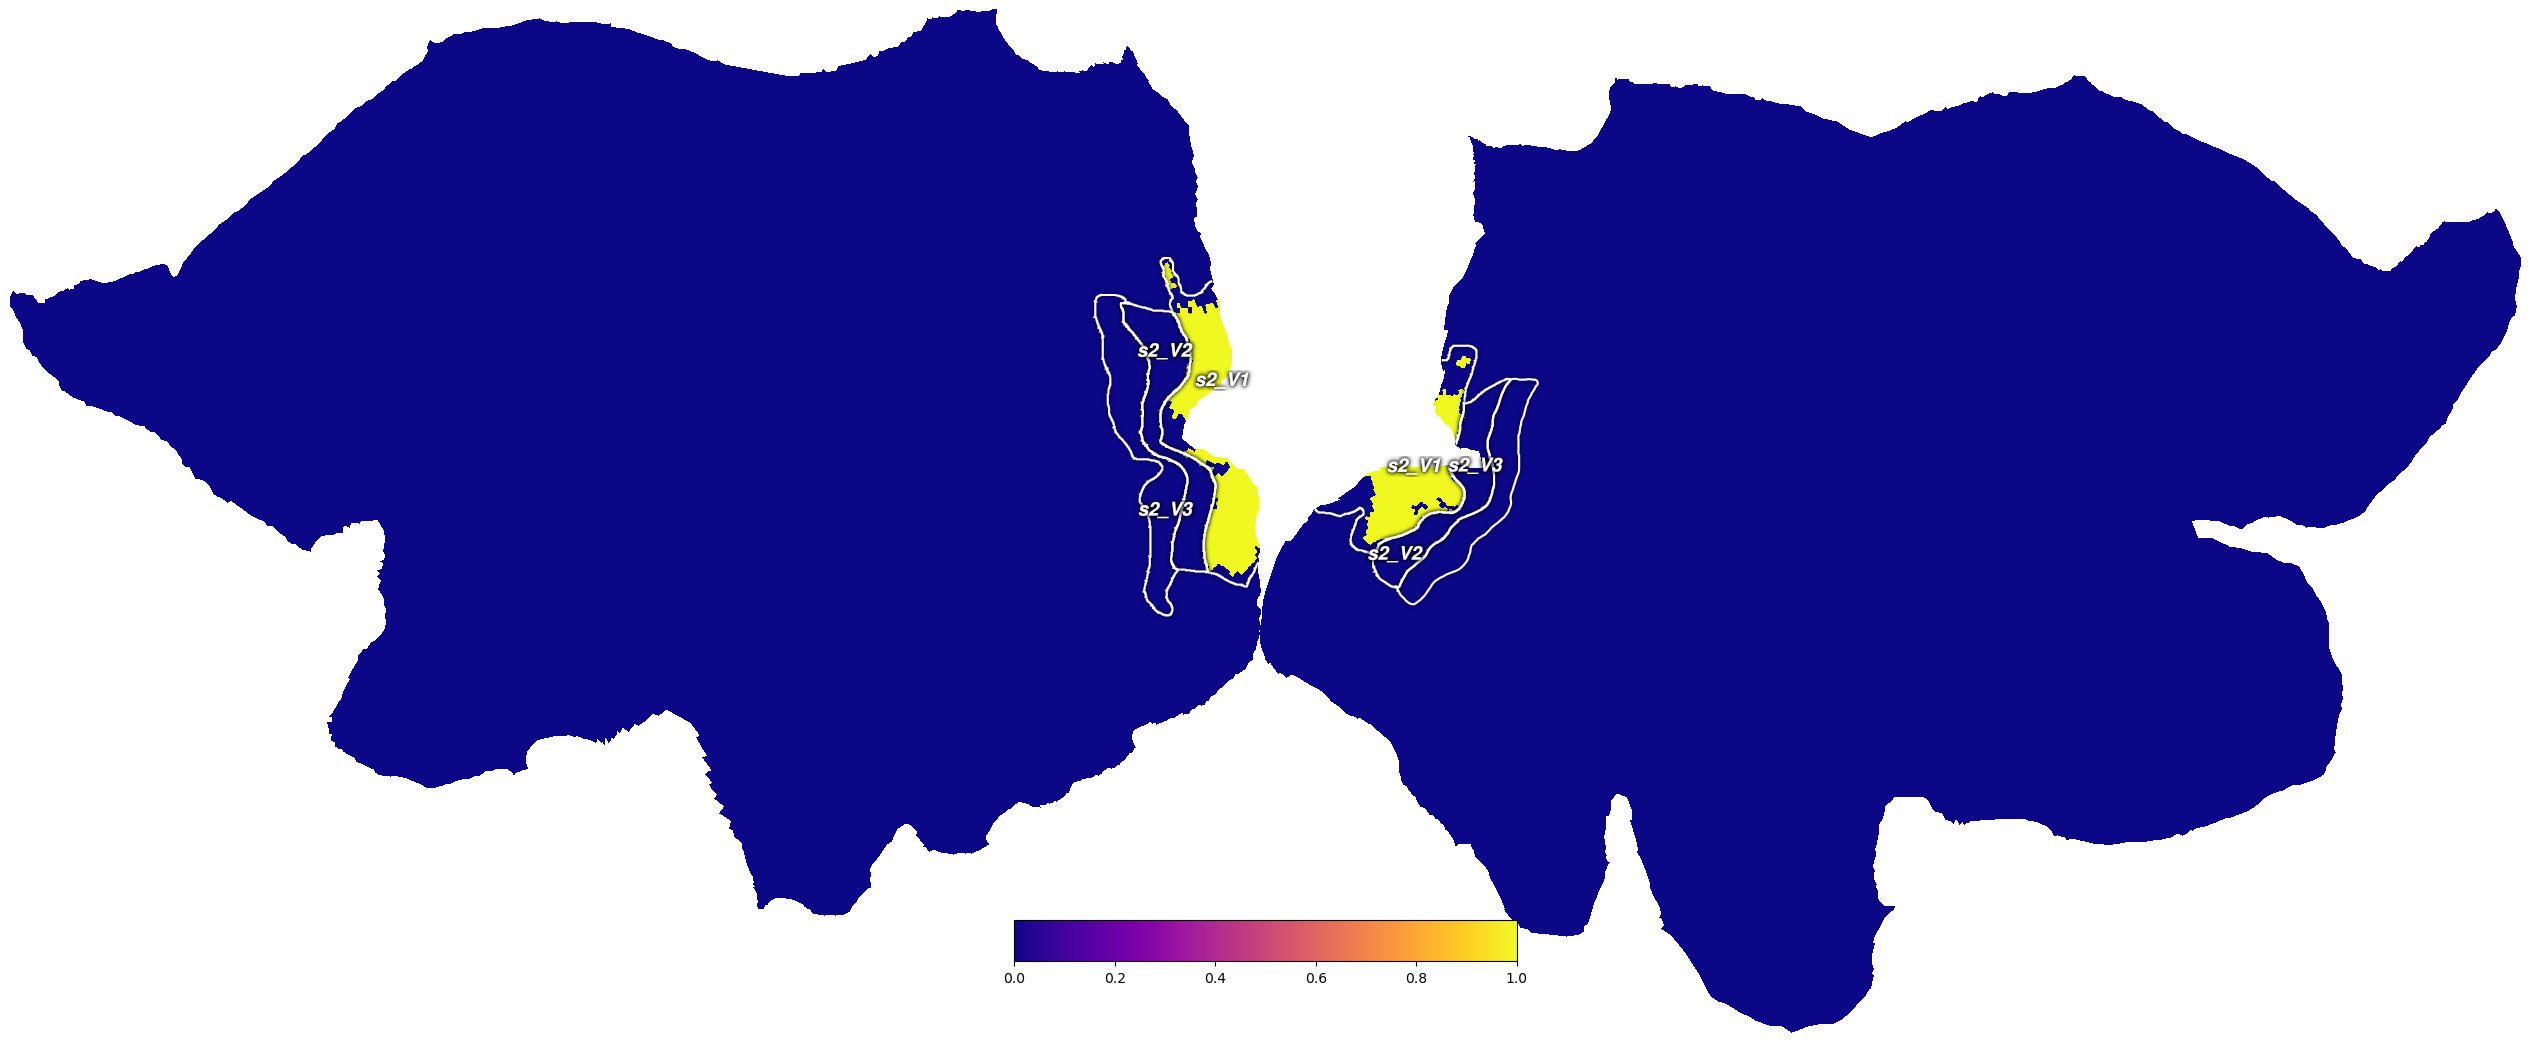

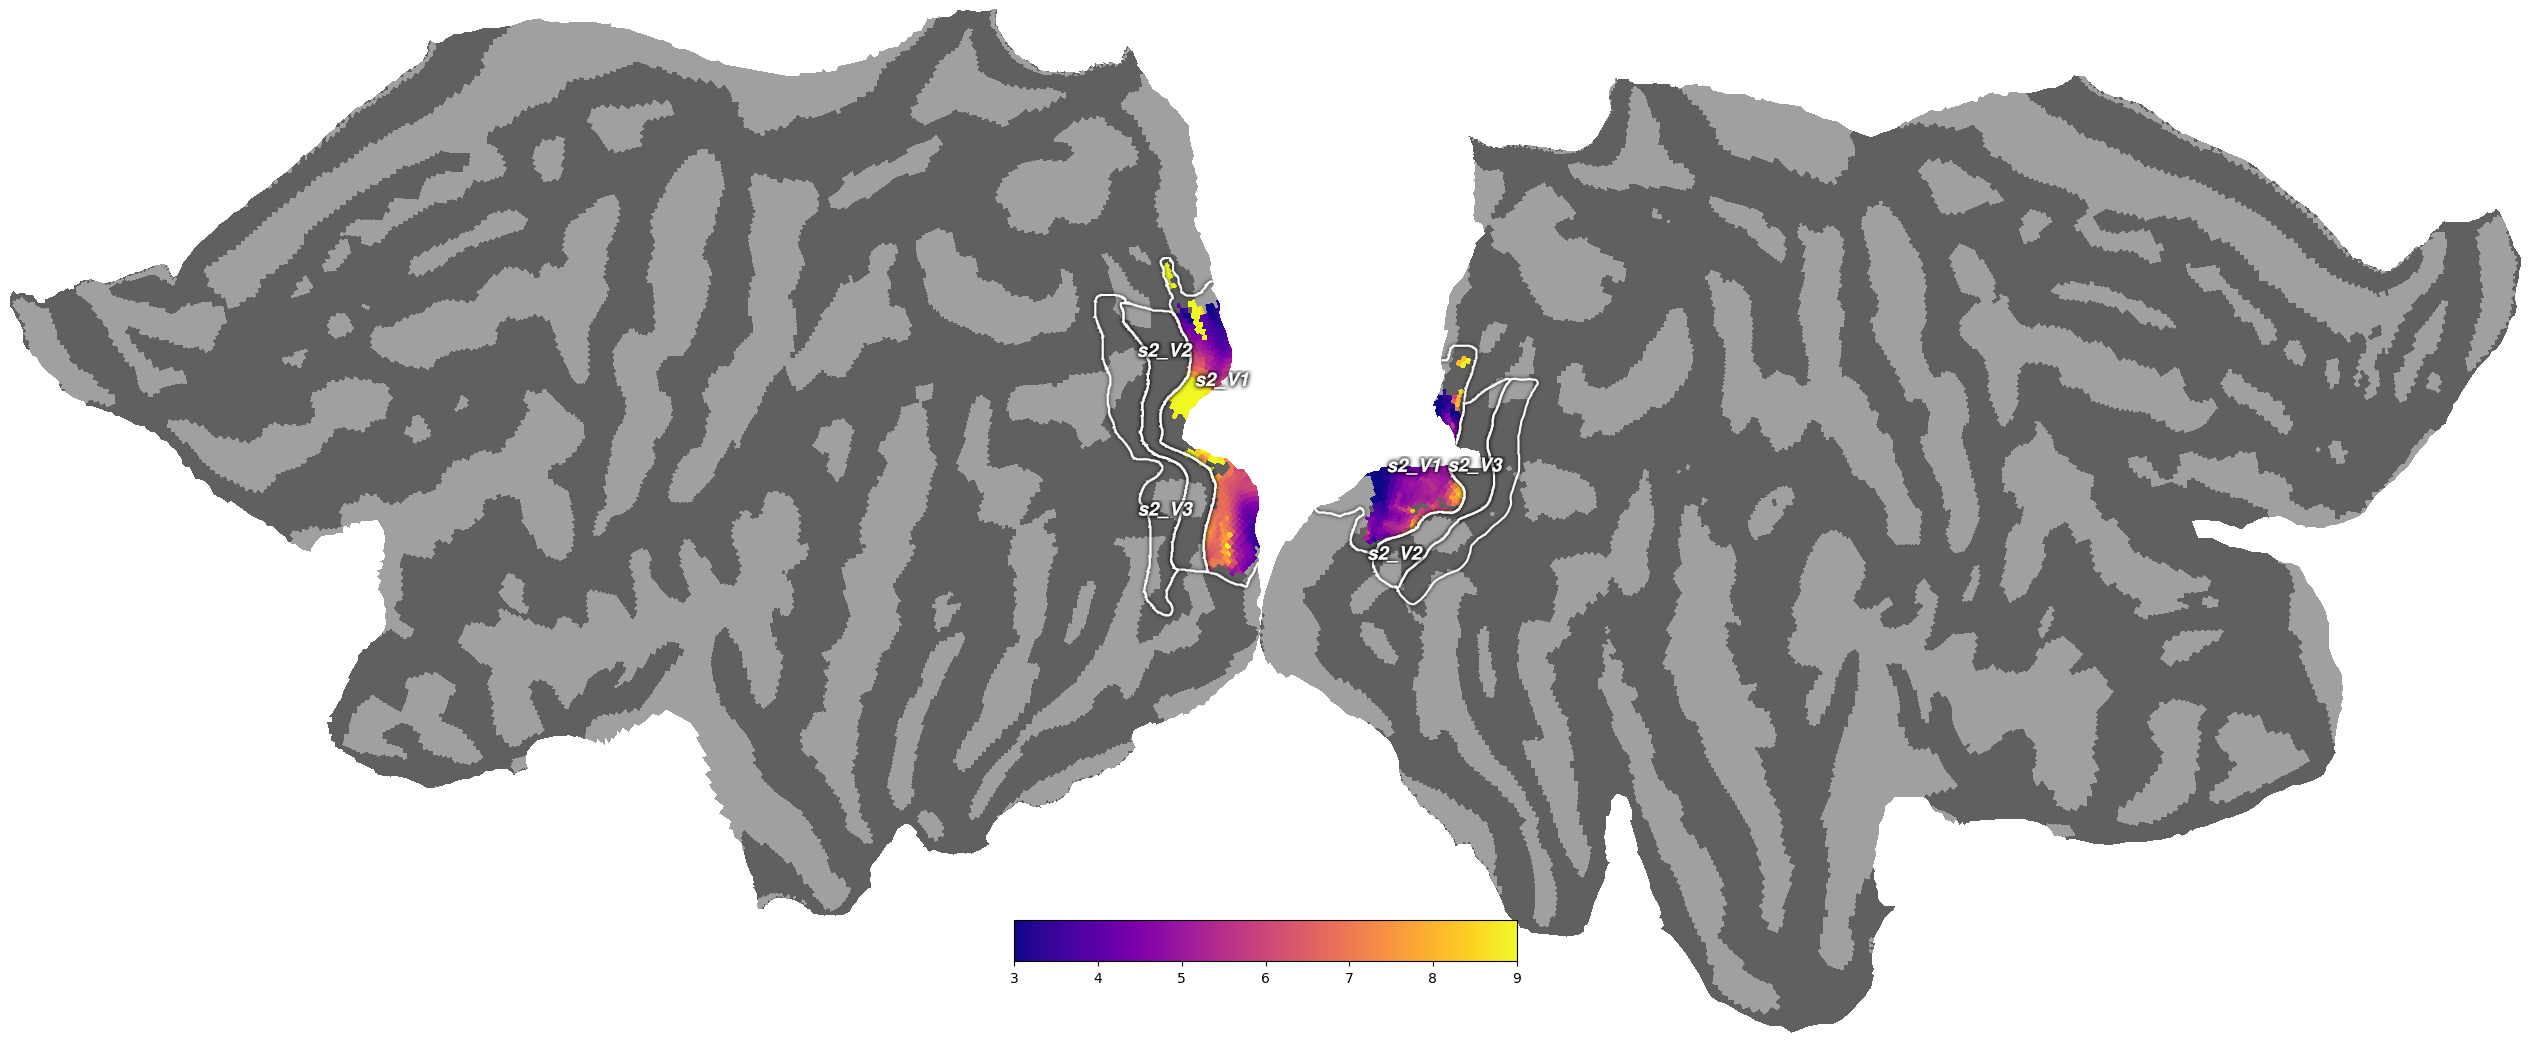

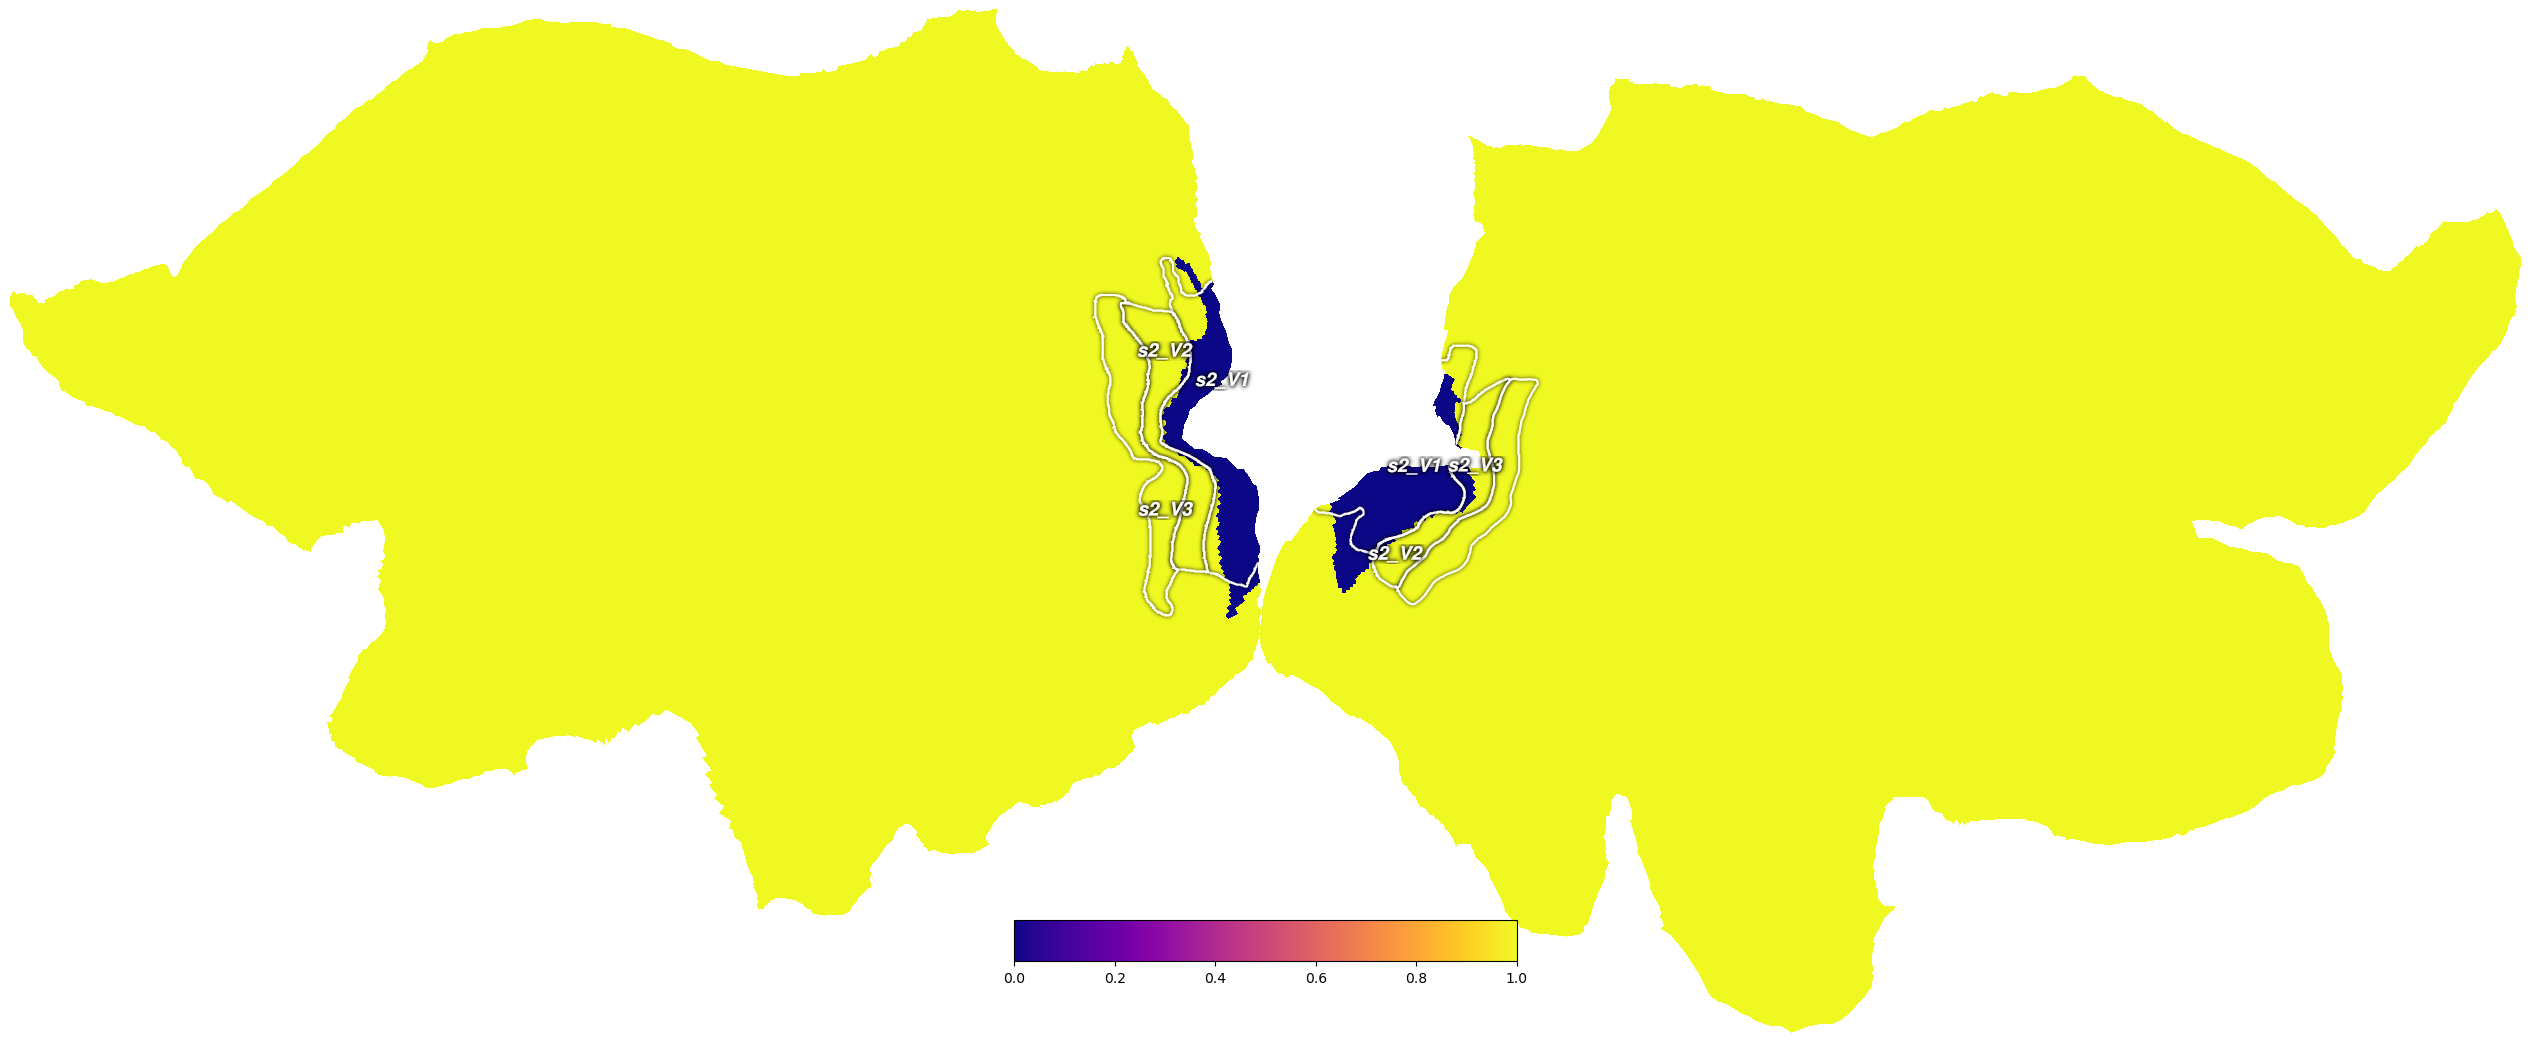

In [173]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF

cx.quickshow(cx.Vertex(myv1surf.intmask, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);
cx.quickshow(cx.Vertex(toplot, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=3, vmax=9), with_curvature=True);
cx.quickshow(cx.Vertex(brainmask.astype(int), subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


In [202]:
np.save(f'/tank/klundert/DMs/distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/DMs/subsurface_verts_sub-0{sub}_hcp_NoR2.npy', myv1surf.subsurface_verts)


In [203]:
np.save(f'/tank/klundert/DMs/visual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.visual_distance_matrix)
np.save(f'/tank/klundert/DMs/logvisual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/DMs/brainmask_sub-0{sub}_NoR2.npy', brainmask)

In [205]:
np.load(f'/tank/klundert/DMs/distance_matrix_sub-0{sub}_hcp_NoR2.npy').shape

(942, 942)

In [160]:
myv1surf.distance_matrix.shape
# np.load(f'/tank/klundert/DMs/distance_matrix_sub-0{sub}_hcp.npy').shape

(1010, 1010)

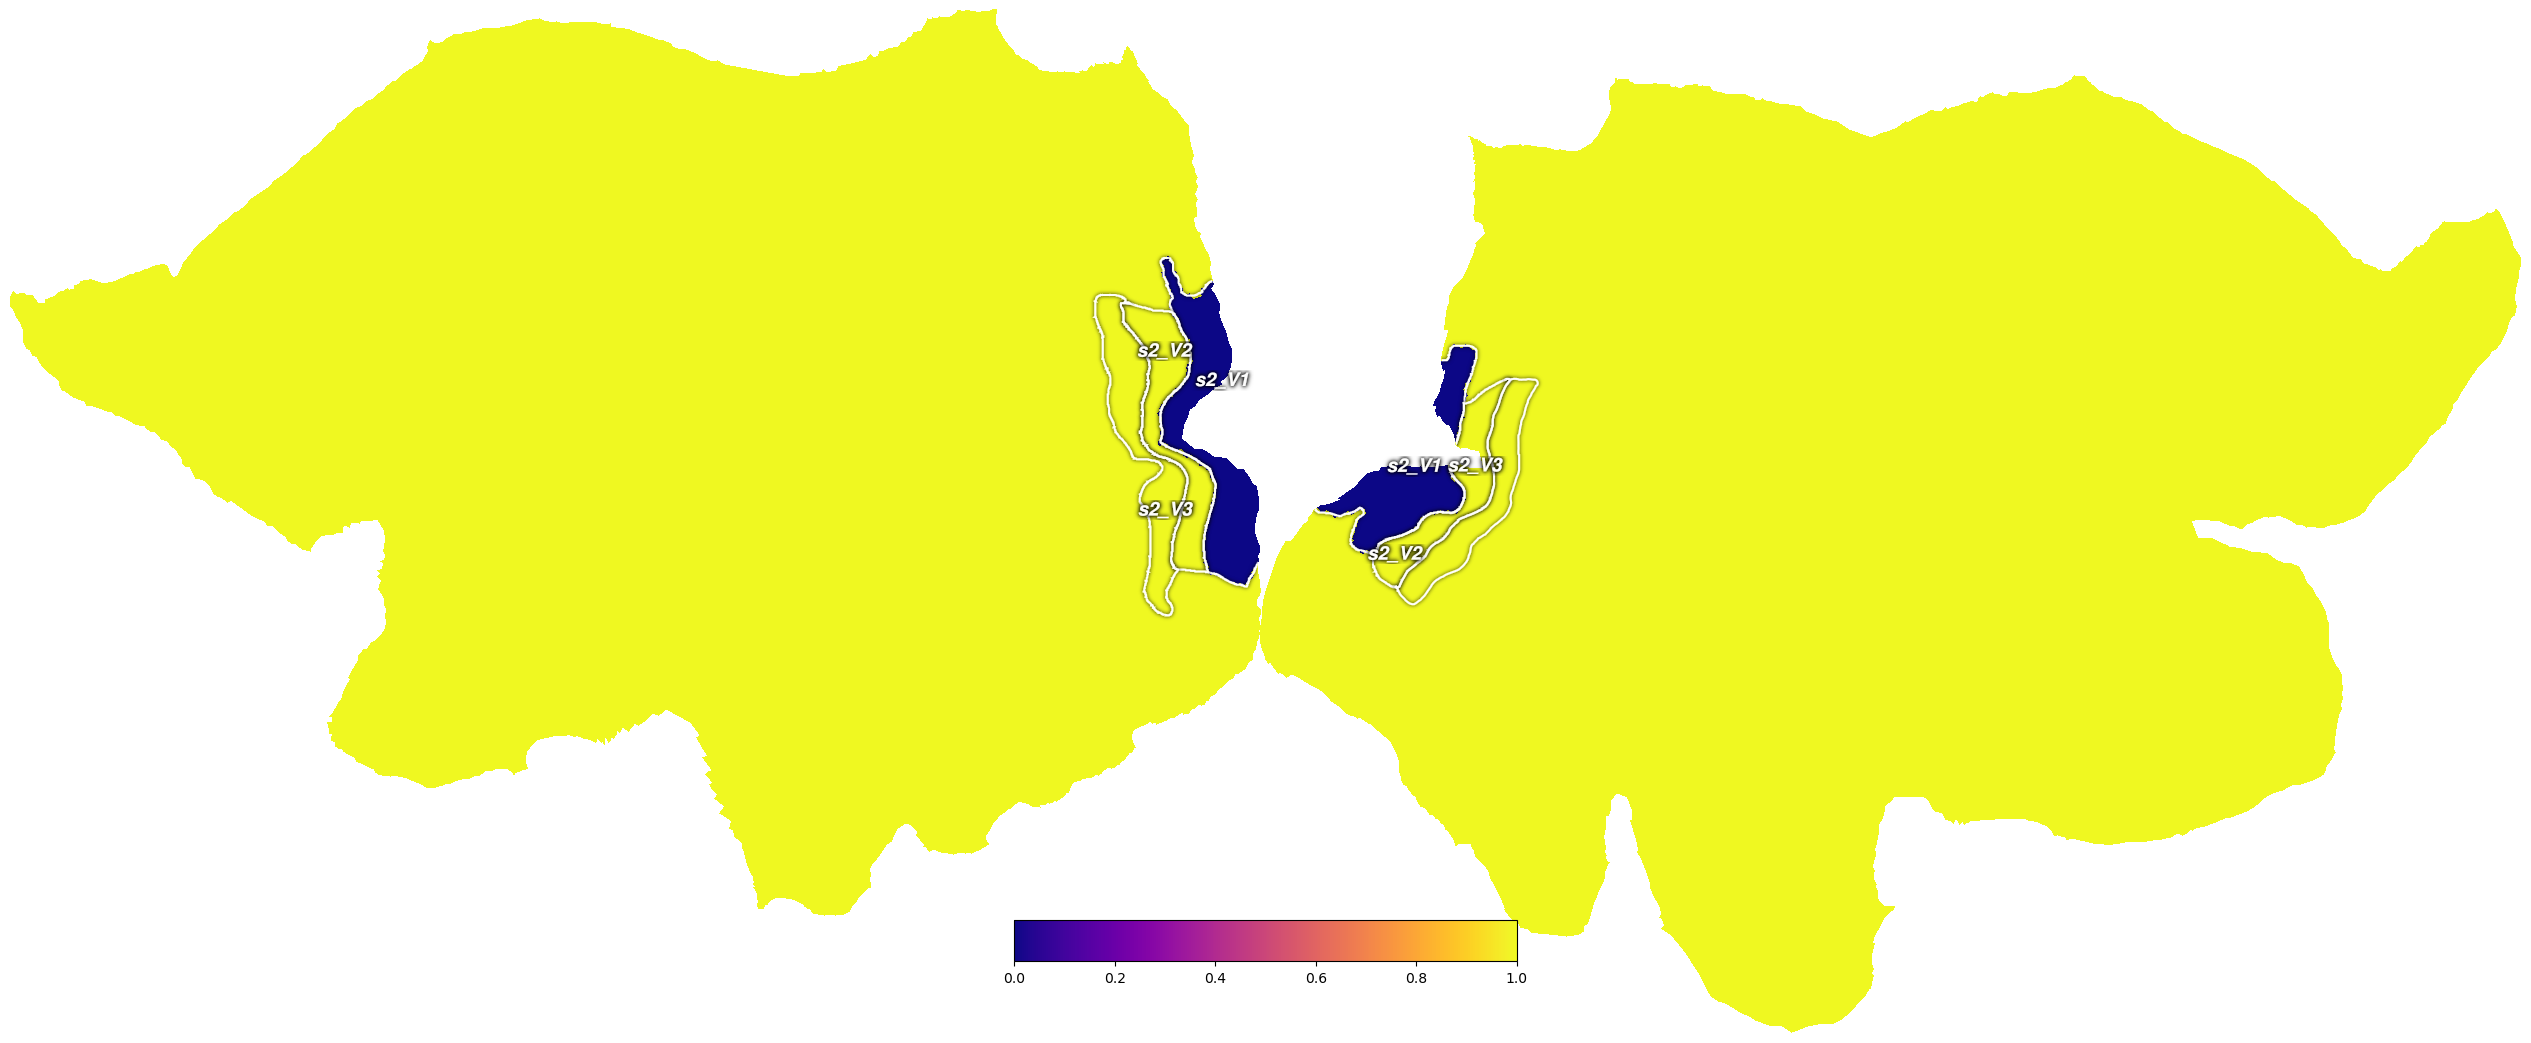

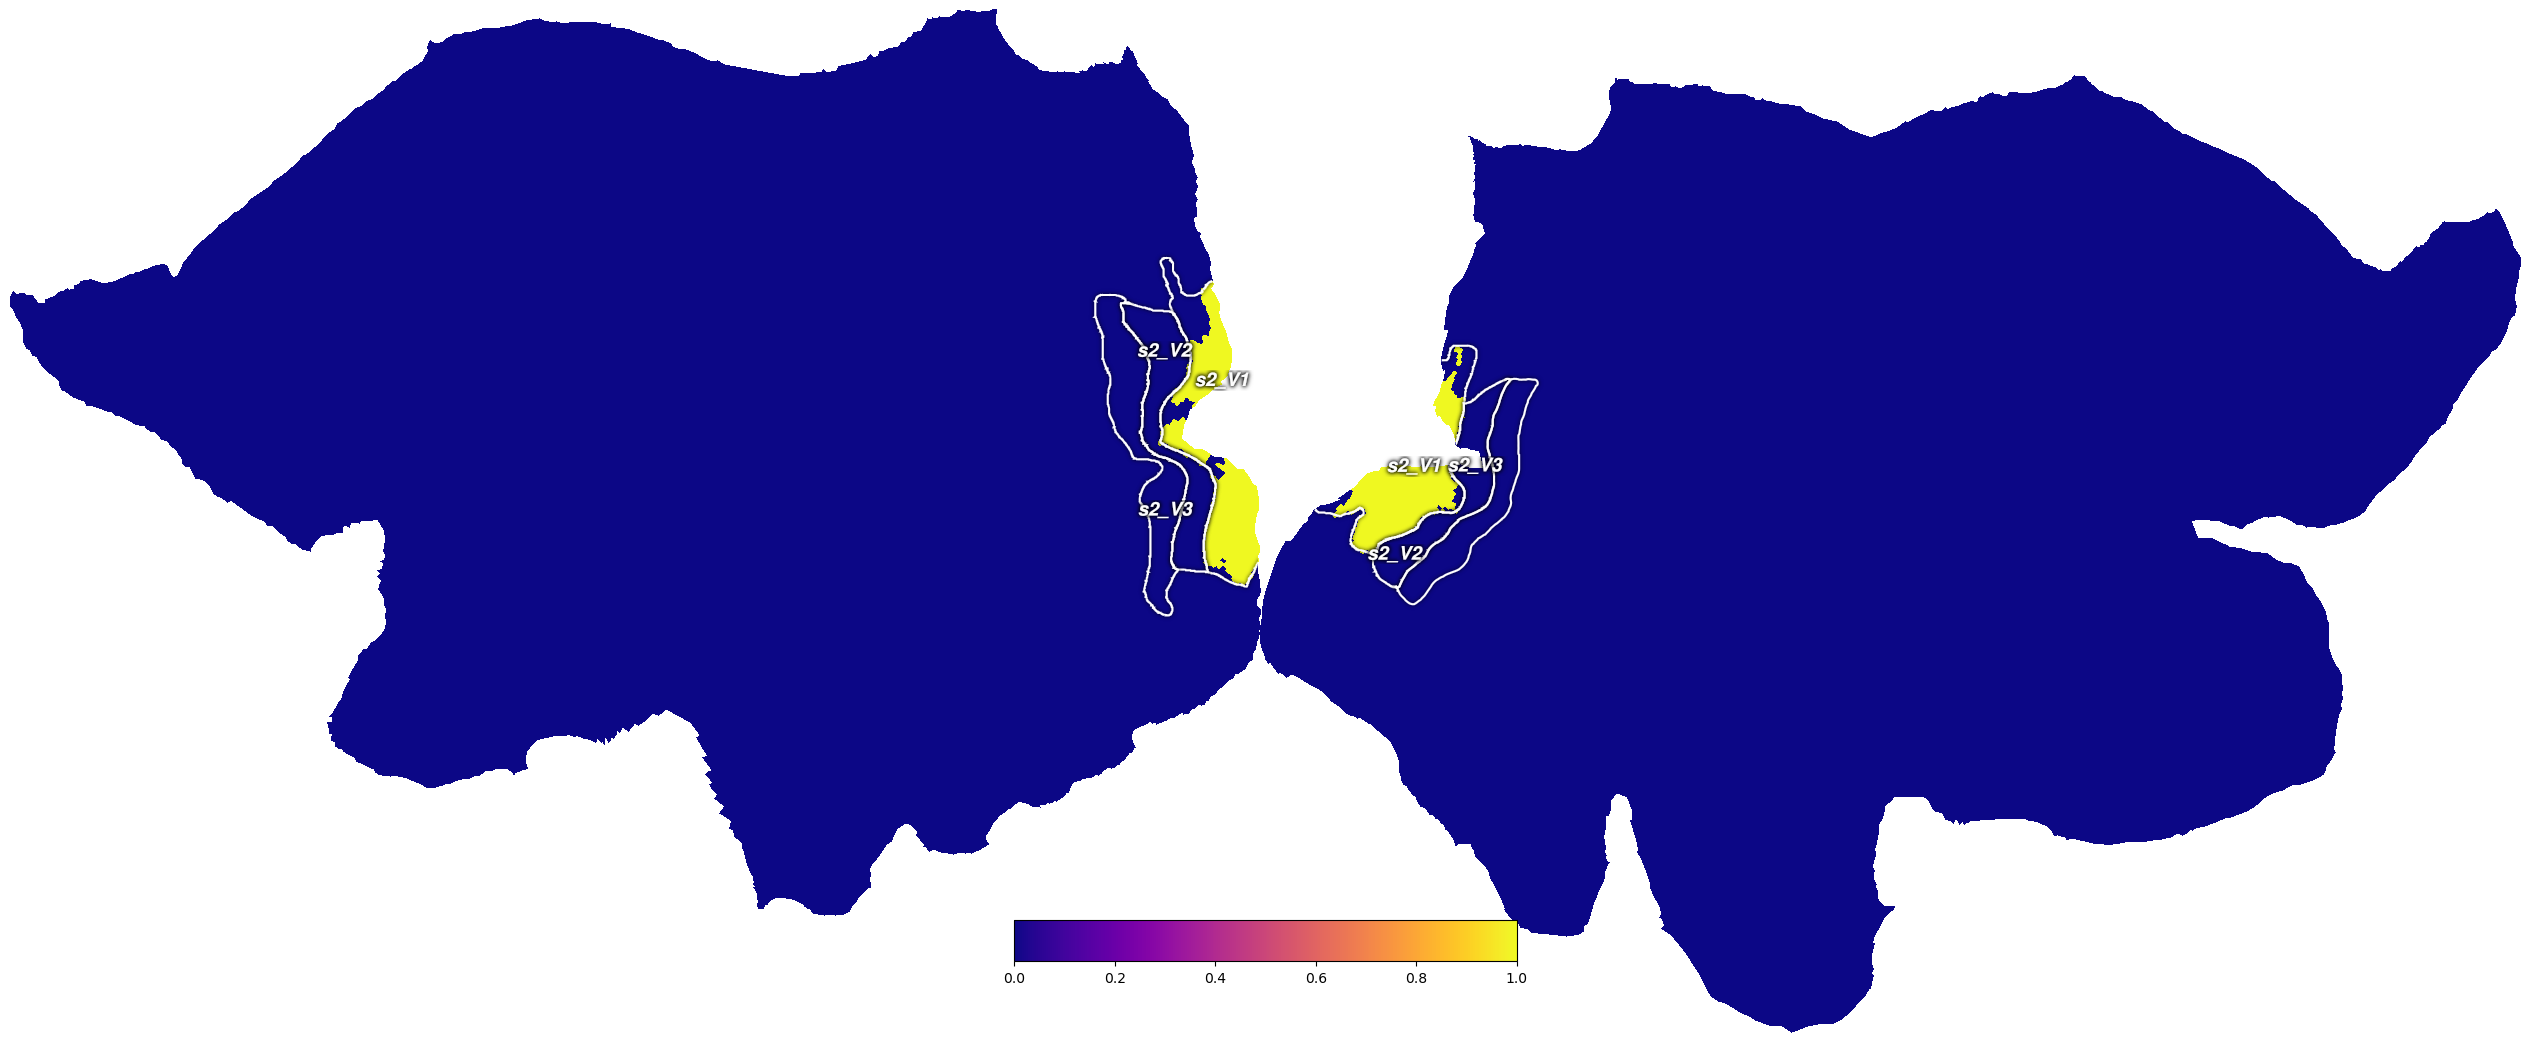

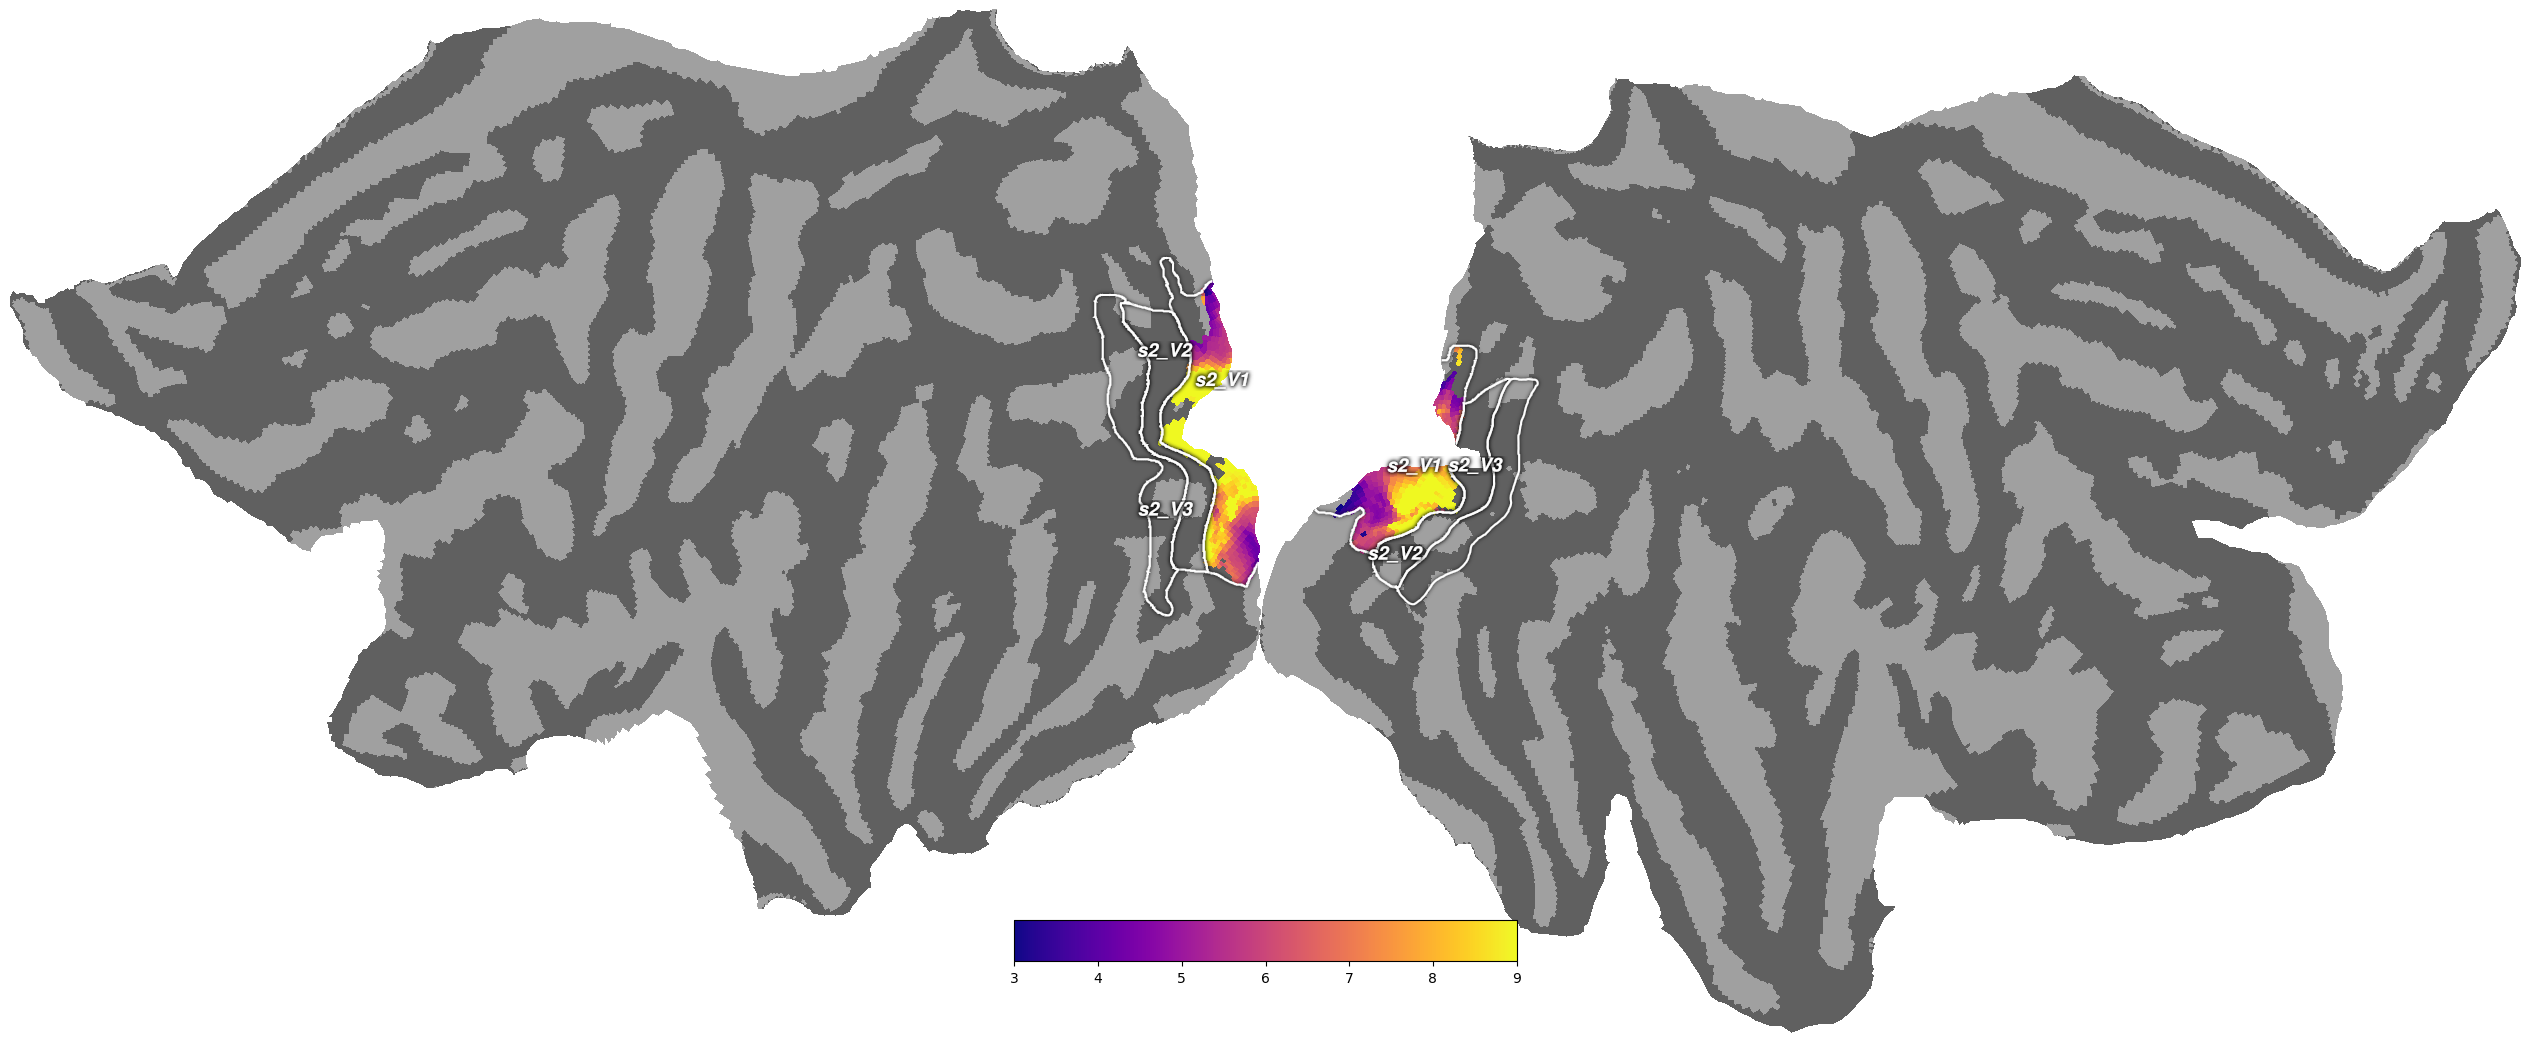

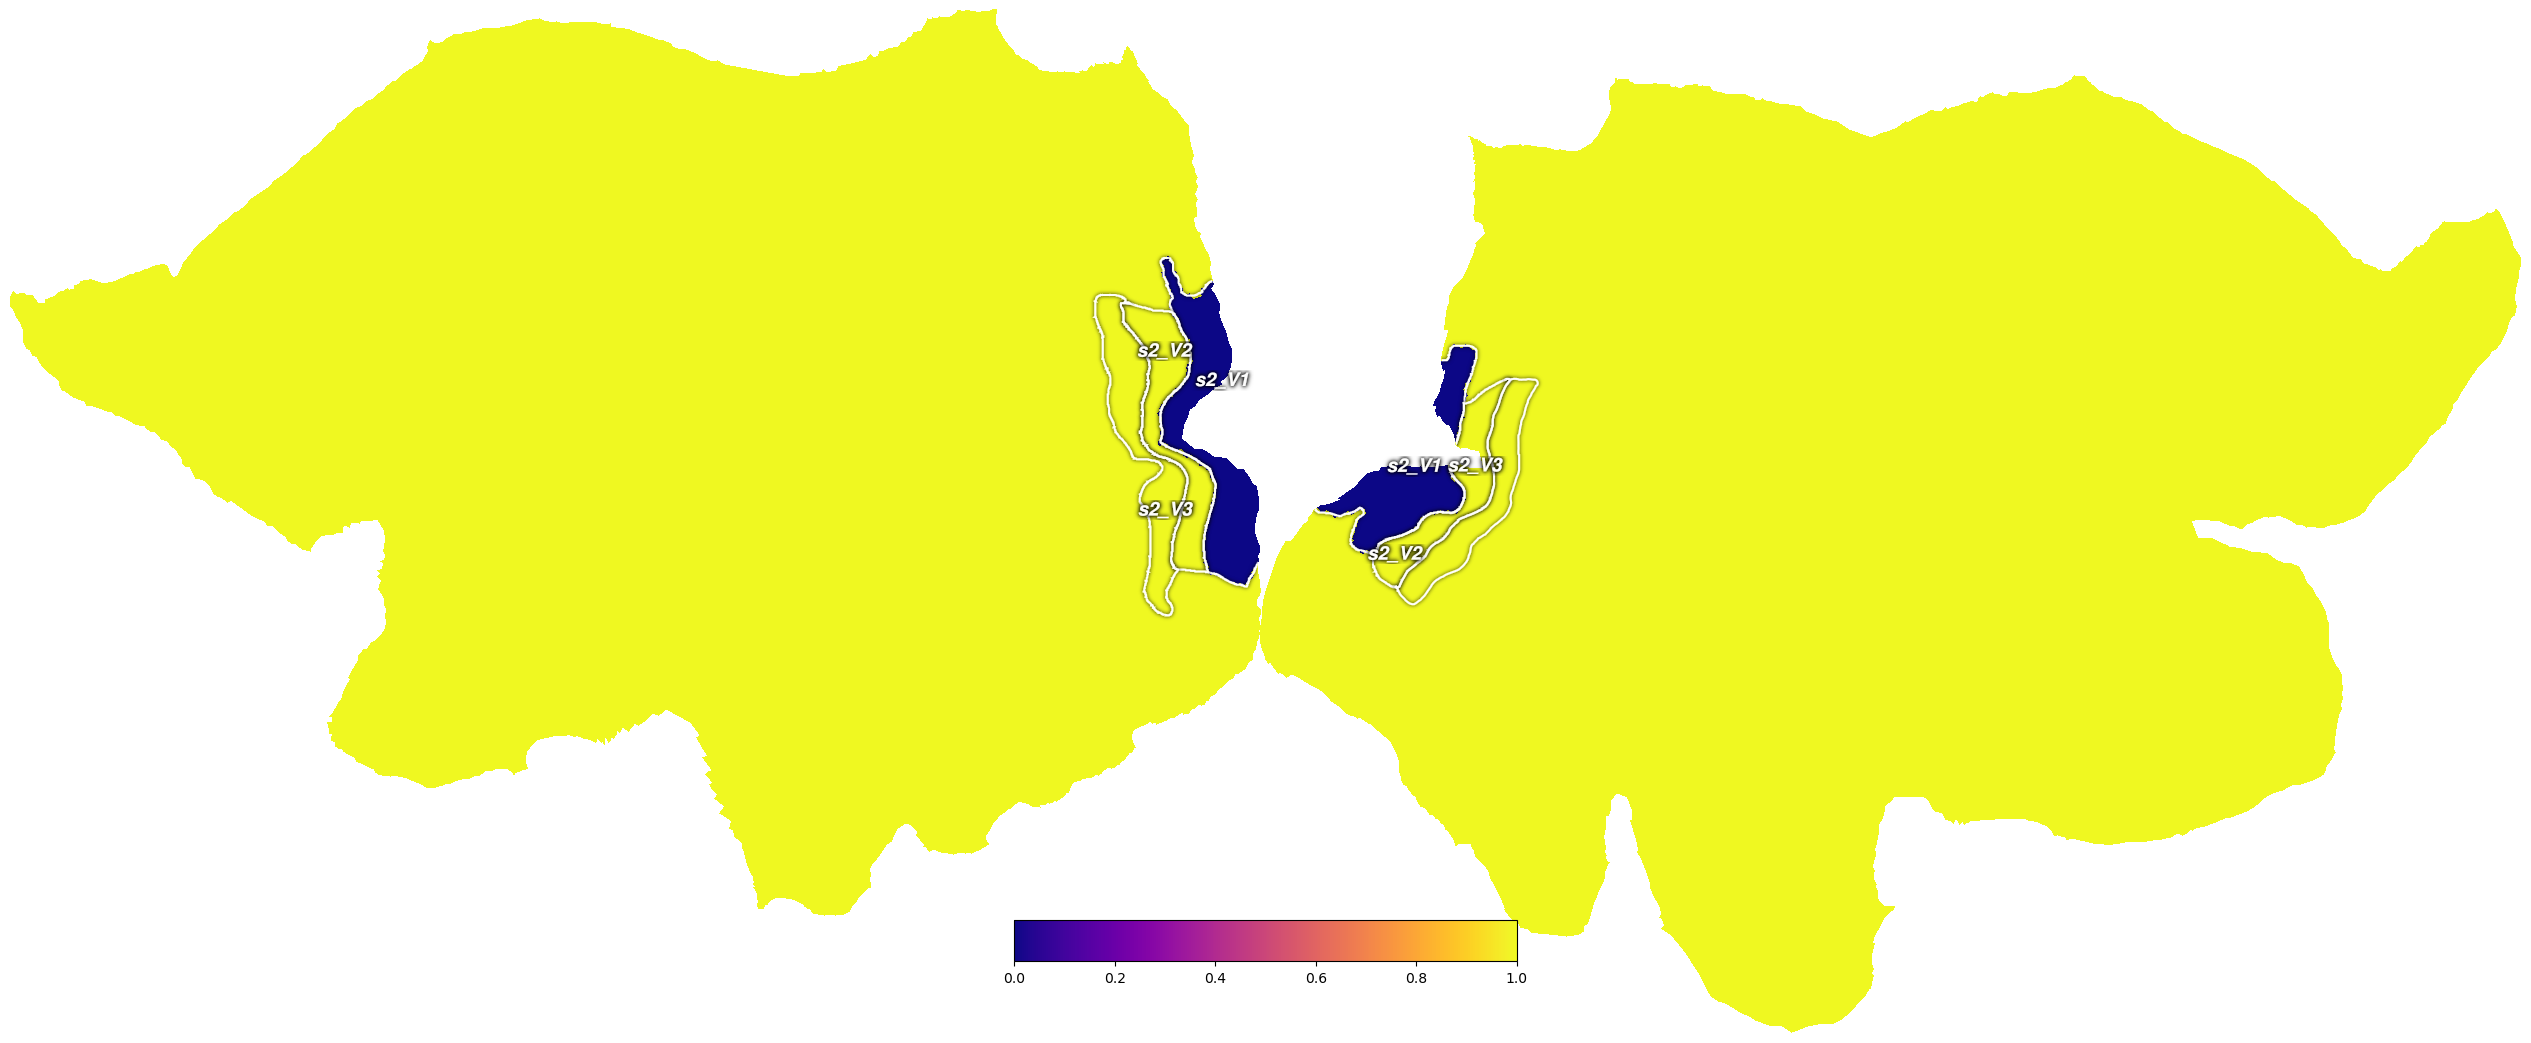

In [20]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF

cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True)
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=3, vmax=9), with_curvature=True)
cx.quickshow(cx.Vertex(brainmask.astype(int), subject='hcp_999999', cmap='plasma', vmin=0, vmax=1), with_curvature=True)


## more experimental stuff down here

[34.15895239  0.81852632]


Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

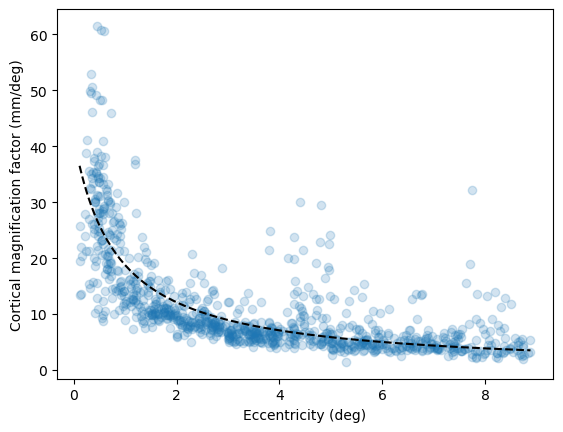

In [52]:
# here I calculate the CMF based on binned eccentricity, where I calculate the
# CMF based on the average distance between vertices in mm cortex per visual degree, 
# within the binened eccentricity range. i.e. 

myv1surf.CMF_matrix.shape

tmask = myv1surf.tofit_x < 1

tmask1 = (myv1surf.tofit_x >= 1) * (myv1surf.tofit_x < 2)
tmask2 = (myv1surf.tofit_x >= 2) * (myv1surf.tofit_x < 3)
tmask3 = (myv1surf.tofit_x >= 3) * (myv1surf.tofit_x < 4)
tmask4 = (myv1surf.tofit_x >= 4) * (myv1surf.tofit_x < 5)
tmask5 = (myv1surf.tofit_x >= 5) * (myv1surf.tofit_x < max_ecc_size)


# ((tofit_x >= 1) * (tofit_x < 2)).sum()

myv1surf.CMF_matrix

fmask = np.ix_(tmask, tmask)
fmask1 = np.ix_(tmask1, tmask1)
fmask2 = np.ix_(tmask2, tmask2)
fmask3 = np.ix_(tmask3, tmask3)
fmask4 = np.ix_(tmask4, tmask4)
fmask5 = np.ix_(tmask5, tmask5)

a=np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)
b=np.nanmean(myv1surf.CMF_matrix[fmask1], axis=1)
c=np.nanmean(myv1surf.CMF_matrix[fmask2], axis=1)
d=np.nanmean(myv1surf.CMF_matrix[fmask3], axis=1)
e=np.nanmean(myv1surf.CMF_matrix[fmask4], axis=1)
f=np.nanmean(myv1surf.CMF_matrix[fmask5], axis=1)



x = np.concatenate((myv1surf.tofit_x[tmask], myv1surf.tofit_x[tmask1], myv1surf.tofit_x[tmask2], myv1surf.tofit_x[tmask3], myv1surf.tofit_x[tmask4], myv1surf.tofit_x[tmask5]))

y = np.concatenate((a,b,c,d,e,f))



tofit_x = x
tofit_y = y

myv1surf.CMF_matrix

pars, cov = curve_fit(f=magnification, xdata=tofit_x, 
              ydata=tofit_y, p0=[40, 6], method='trf')



# pars = [20.14400586, 0.7611809]

# extract the parameters
lamb, ecc0 = pars

# pars = [50, 4]
print(pars)


plotx = np.linspace(start=np.nanmin(tofit_x), stop=np.nanmax(tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

In [23]:
from scipy import stats

bins = stats.binned_statistic(myv1surf.tofit_x, myv1surf.tofit_y, 'median', bins=100)

# plt.plot(bins[1], bins[0])
newbins = []
for i in range(100):
    newbins.append(np.mean([bins[1][0+i], bins[1][1+i]]))
bins[0]

array([10.55653189,  9.81235782, 10.04438066,  9.80889615,  9.17925701,
       10.48312597, 10.37293185,  9.36304553, 10.20151313,  9.40435479,
        9.63484371,  9.19667459,  9.61346778,  8.71964922,  9.15387125,
        8.86639432,  8.96328998,  8.22525959,  8.64955022,  8.17781168,
        8.61286355,  8.97205612,  8.90242779,  8.51230675,  8.54631734,
        8.58924649,  8.02307241,  8.93447387,  7.07673393,  7.2988123 ,
        7.04513361,  7.18897189,  6.95986551,  6.53521547,  6.81669371,
        6.61718848,  6.50031869,  6.43693894,  6.30093705,  6.25275881,
        6.43839621,  6.30507037,  5.88960878,  5.70762906,  5.8053546 ,
        5.9775967 ,  5.78469458,  5.43765968,  5.61462774,  5.24315116,
        5.59284281,  5.80557929,  5.20884422,  5.59404472,  5.49791907,
        5.25150515,  5.48498117,  5.51081335,  6.29105068,  5.47762254,
        5.01628619,  5.32186691,  5.32441926,  4.84759833,  4.85751312,
        4.84672438,  4.96772203,  4.98069573,  4.73285662,  4.98

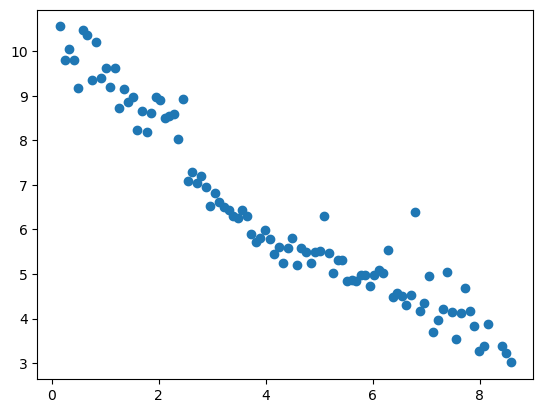

In [24]:
np.array(newbins).shape

plt.scatter(np.array(newbins), bins[0])


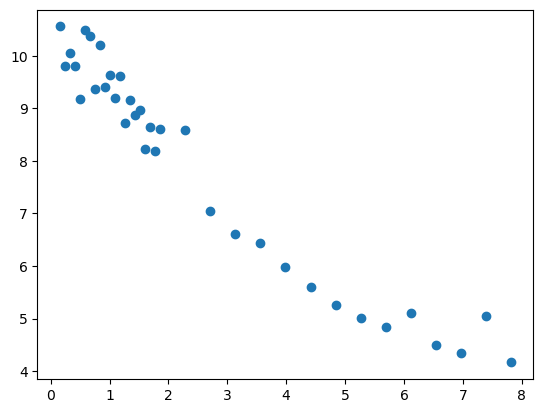

In [25]:
# plt.scatter(np.array(newbins), bins[0])


plt.scatter(np.hstack([np.array(newbins)[:20], np.array(newbins)[20::5]]), np.hstack([bins[0][:20], bins[0][20::5]]))

In [28]:
myv1surf.CMF_matrix.shape

tmask = myv1surf.tofit_x < 1

tmask1 = (myv1surf.tofit_x >= 1) * (myv1surf.tofit_x < 2)
tmask2 = (myv1surf.tofit_x >= 2) * (myv1surf.tofit_x < 3)
tmask3 = (myv1surf.tofit_x >= 3) * (myv1surf.tofit_x < 4)
tmask4 = (myv1surf.tofit_x >= 4) * (myv1surf.tofit_x < 5)
tmask5 = (myv1surf.tofit_x >= 5) * (myv1surf.tofit_x < max_ecc_size)


# ((tofit_x >= 1) * (tofit_x < 2)).sum()

myv1surf.CMF_matrix

fmask = np.ix_(tmask, tmask)
fmask1 = np.ix_(tmask1, tmask1)
fmask2 = np.ix_(tmask2, tmask2)
fmask3 = np.ix_(tmask3, tmask3)
fmask4 = np.ix_(tmask4, tmask4)
fmask5 = np.ix_(tmask5, tmask5)




myv1surf.CMF_matrix[fmask].shape



(129, 129)

In [29]:
a=np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)
b=np.nanmean(myv1surf.CMF_matrix[fmask1], axis=1)
c=np.nanmean(myv1surf.CMF_matrix[fmask2], axis=1)
d=np.nanmean(myv1surf.CMF_matrix[fmask3], axis=1)
e=np.nanmean(myv1surf.CMF_matrix[fmask4], axis=1)
f=np.nanmean(myv1surf.CMF_matrix[fmask5], axis=1)



x = np.concatenate((myv1surf.tofit_x[tmask], myv1surf.tofit_x[tmask1], myv1surf.tofit_x[tmask2], myv1surf.tofit_x[tmask3], myv1surf.tofit_x[tmask4], myv1surf.tofit_x[tmask5]))

y = np.concatenate((a,b,c,d,e,f))






[41.77097361  1.49329115]


Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

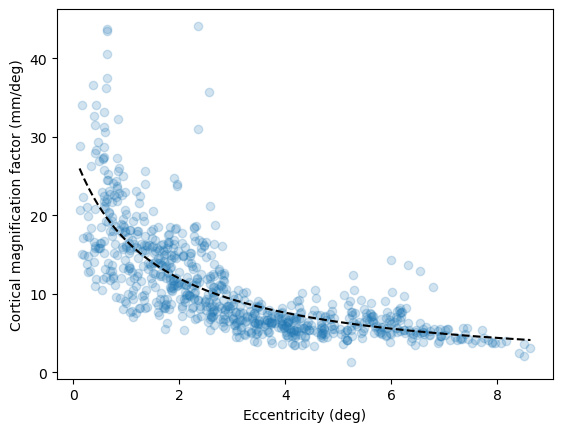

In [30]:
from scipy.optimize import curve_fit

def magnification(x, a, b):
    """magnification
        Function used to fit cortical magnification factor parameters
    """
    return a/(b+x)

incl = 20 # all fist X values
incl_step = 10 # then include every i-th value

tofit_x = np.hstack([np.array(newbins)[:incl], np.array(newbins)[incl::incl_step]])
tofit_y = np.hstack([bins[0][:incl], bins[0][incl::incl_step]])

# tofit_x = myv1surf.tofit_x[myv1surf.tofit_y < 9]
# tofit_y = myv1surf.tofit_y[myv1surf.tofit_y < 9]


tofit_x = myv1surf.tofit_x[tmask]
# tofit_y = myv1surf.tofit_y
tofit_y = np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)

tofit_x = x
tofit_y = y

myv1surf.CMF_matrix

pars, cov = curve_fit(f=magnification, xdata=tofit_x, 
              ydata=tofit_y, p0=[40, 6], method='trf')



# pars = [20.14400586, 0.7611809]

# extract the parameters
lamb, ecc0 = pars

# pars = [50, 4]
print(pars)


plotx = np.linspace(start=np.nanmin(tofit_x), stop=np.nanmax(tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_L.subsurface_vertex_map)[0][0])[0]
/tank/klundert/downloads/cfpy/prfpy/utils.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_R.subsu

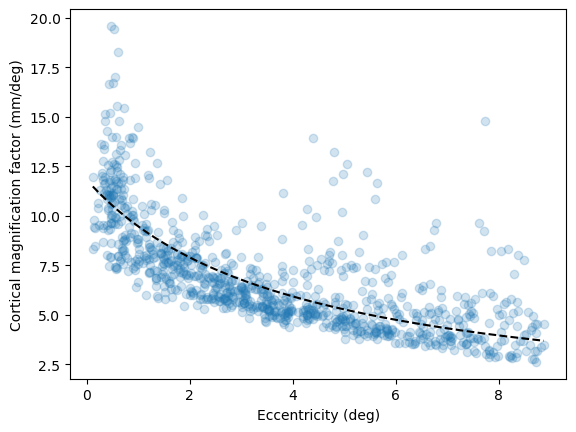

Cortical magnification factor parameters: 
lambda =  47.620485721934976
ecc0 =  4.029060737580369


In [92]:
# V1 based on 

sub = 2
fold = 1

roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.4)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

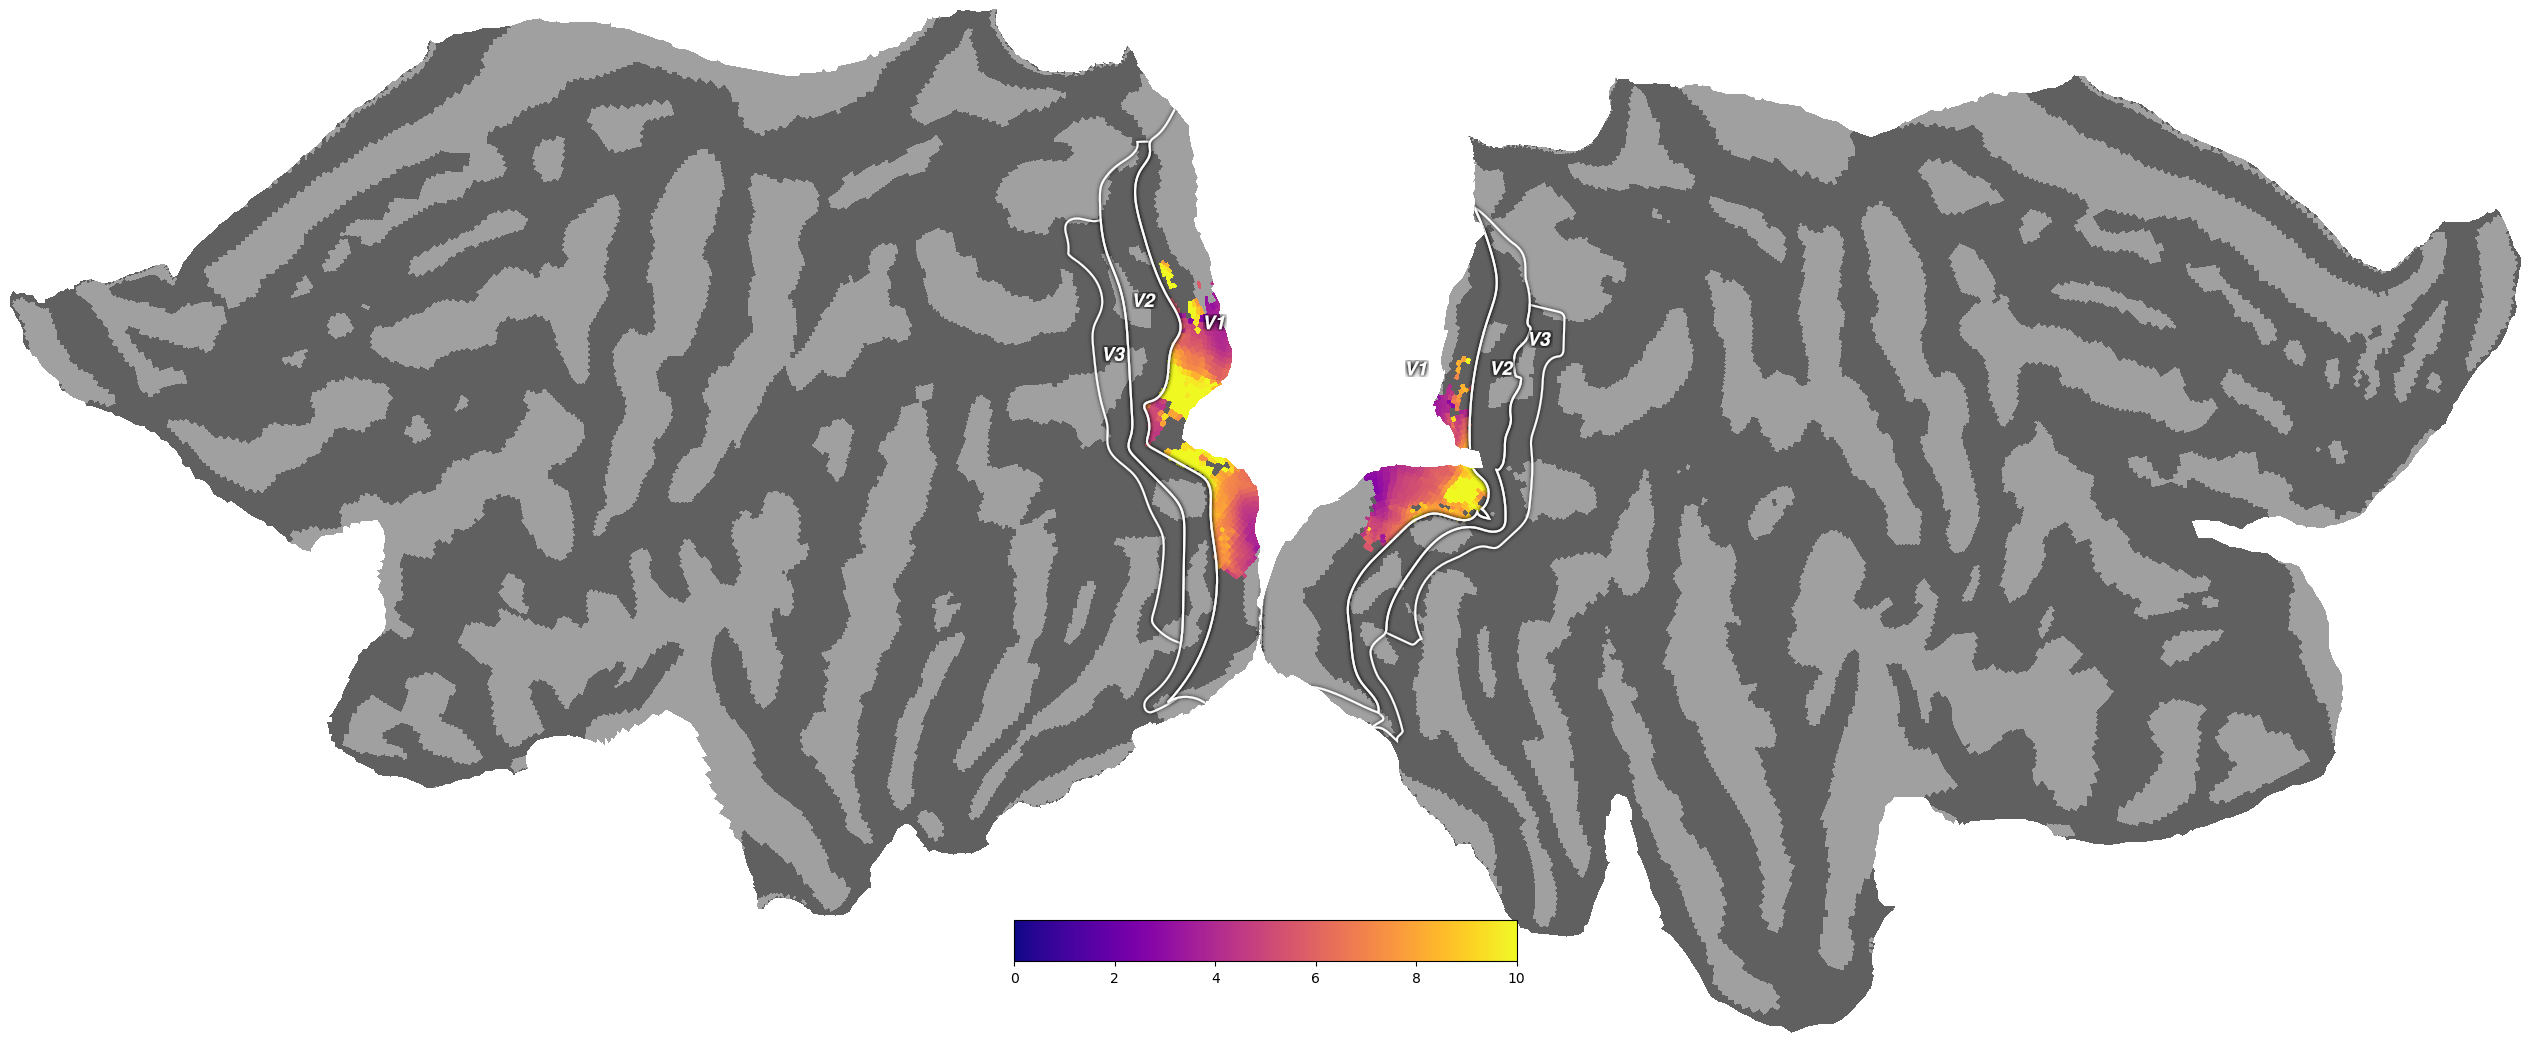

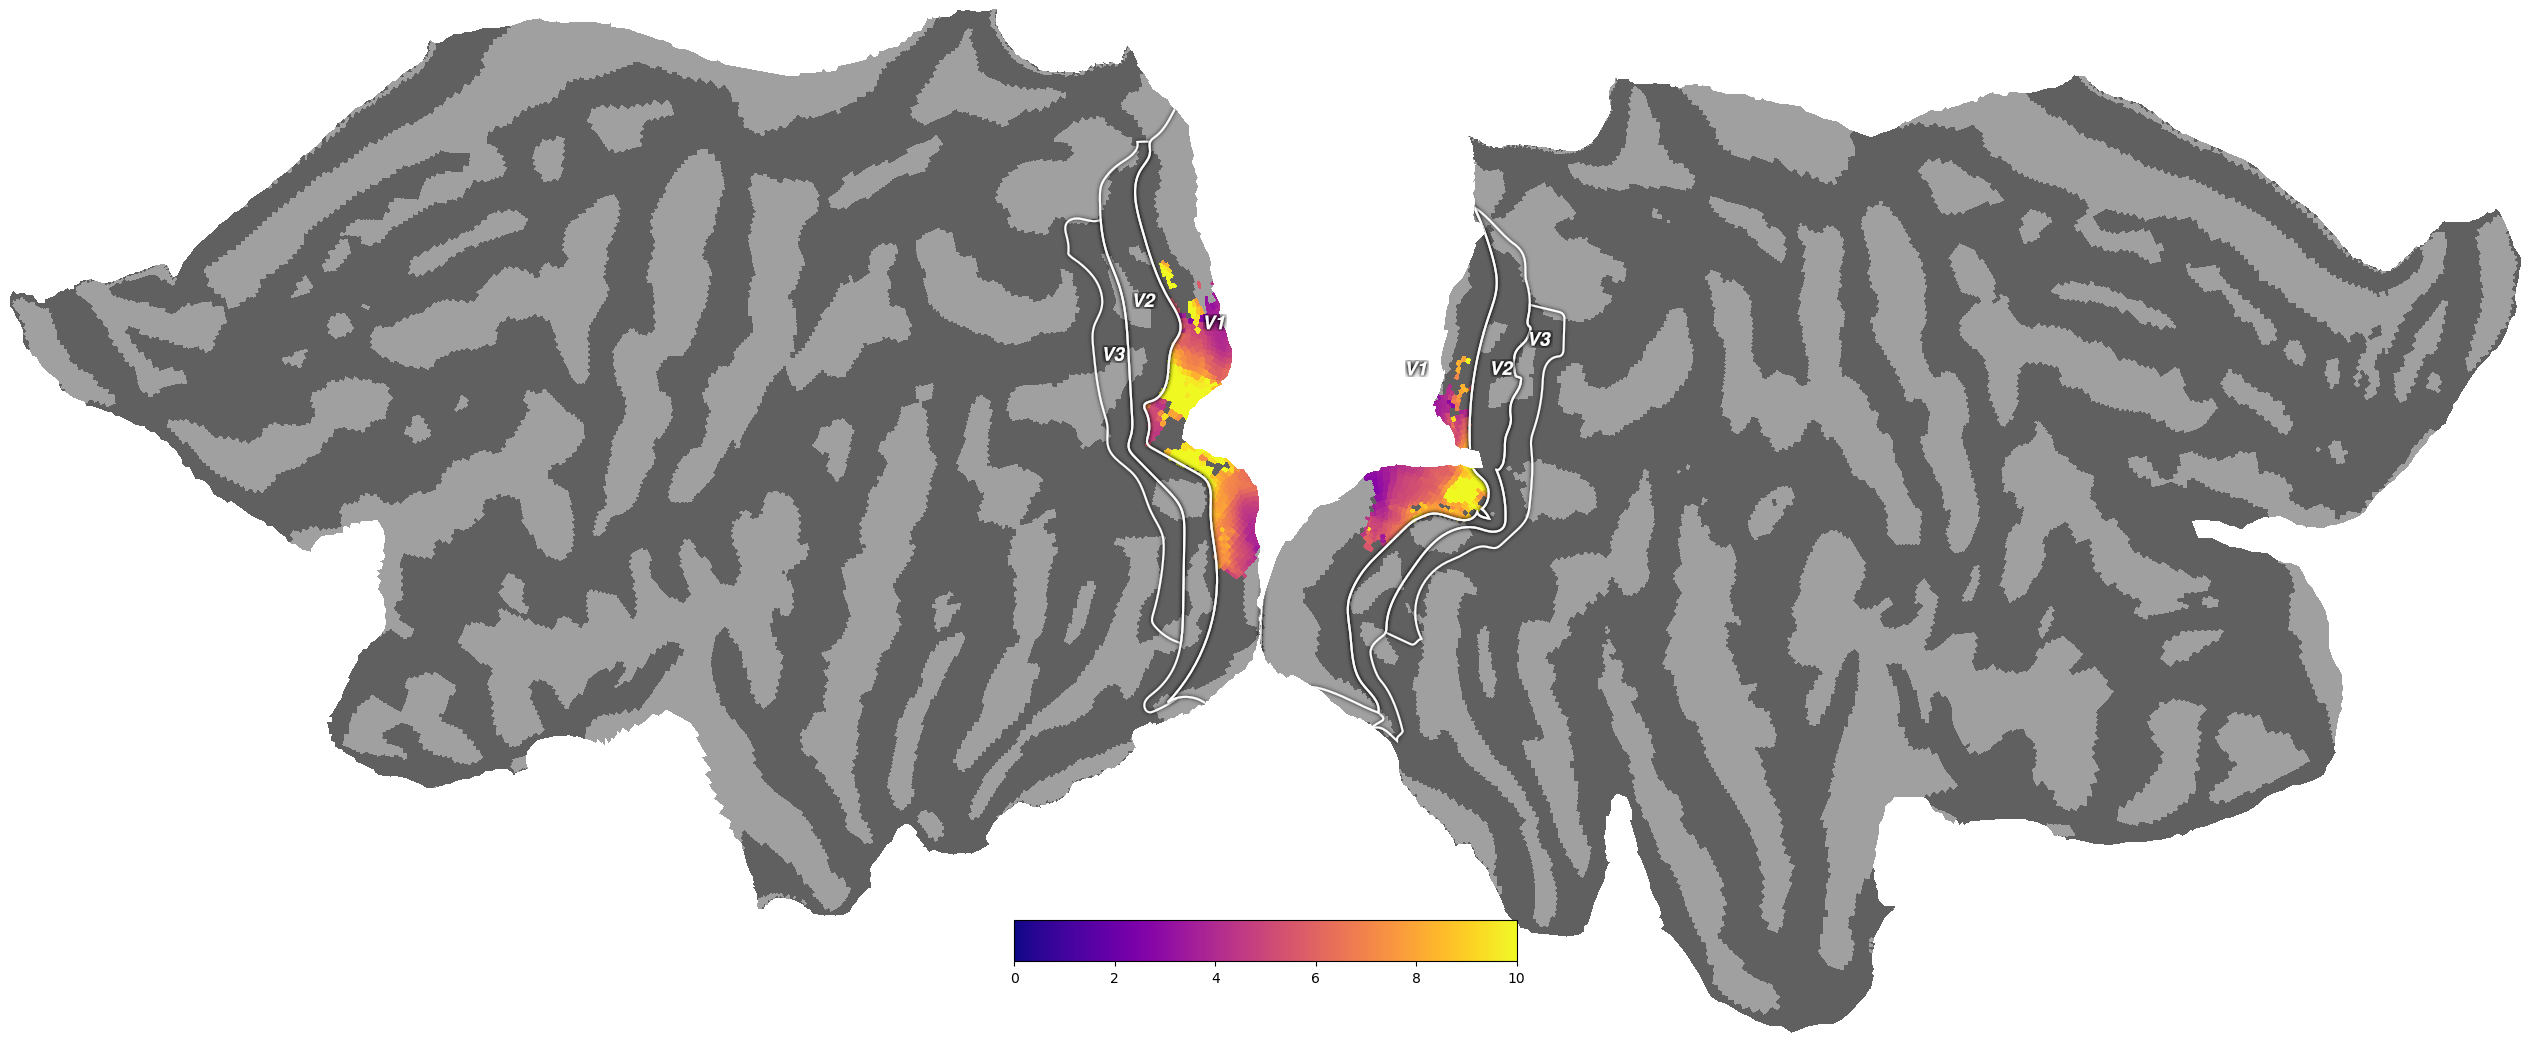

In [94]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True)


In [221]:
myv1surf.visual_distance_matrix
# myv1surf.logvisual_distance_matrix

array([[0.        , 0.1867309 , 0.19251213, ..., 3.03863345, 0.87498388,
        8.78891561],
       [0.1867309 , 0.        , 0.15260642, ..., 2.91821435, 0.77660267,
        8.61236016],
       [0.19251213, 0.15260642, 0.        , ..., 3.06444443, 0.92883665,
        8.71309801],
       ...,
       [3.03863345, 2.91821435, 3.06444443, ..., 0.        , 2.16720745,
        6.33038931],
       [0.87498388, 0.77660267, 0.92883665, ..., 2.16720745, 0.        ,
        8.07876231],
       [8.78891561, 8.61236016, 8.71309801, ..., 6.33038931, 8.07876231,
        0.        ]])

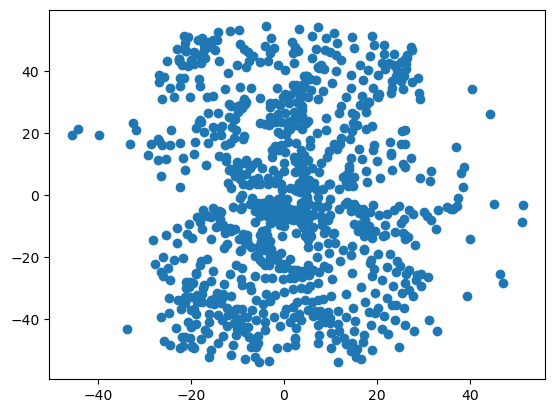

In [482]:
plt.scatter(myv1surf.logxy_verts['logx'], myv1surf.logxy_verts['logy'])

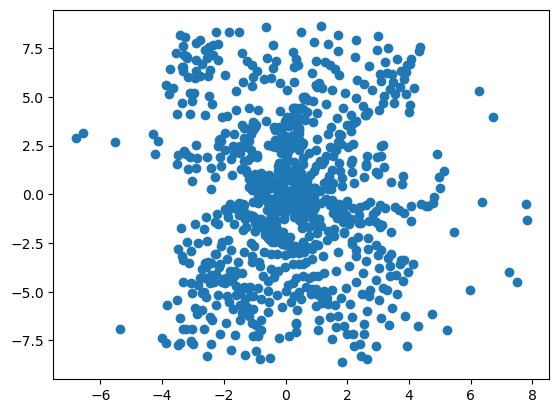

In [483]:
plt.scatter(myv1surf.xy_verts['x'], myv1surf.xy_verts['y'])

In [230]:
sub=2
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts_sub-0{sub}_fsnative.npy', myv1surf.subsurface_verts)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.visual_distance_matrix)

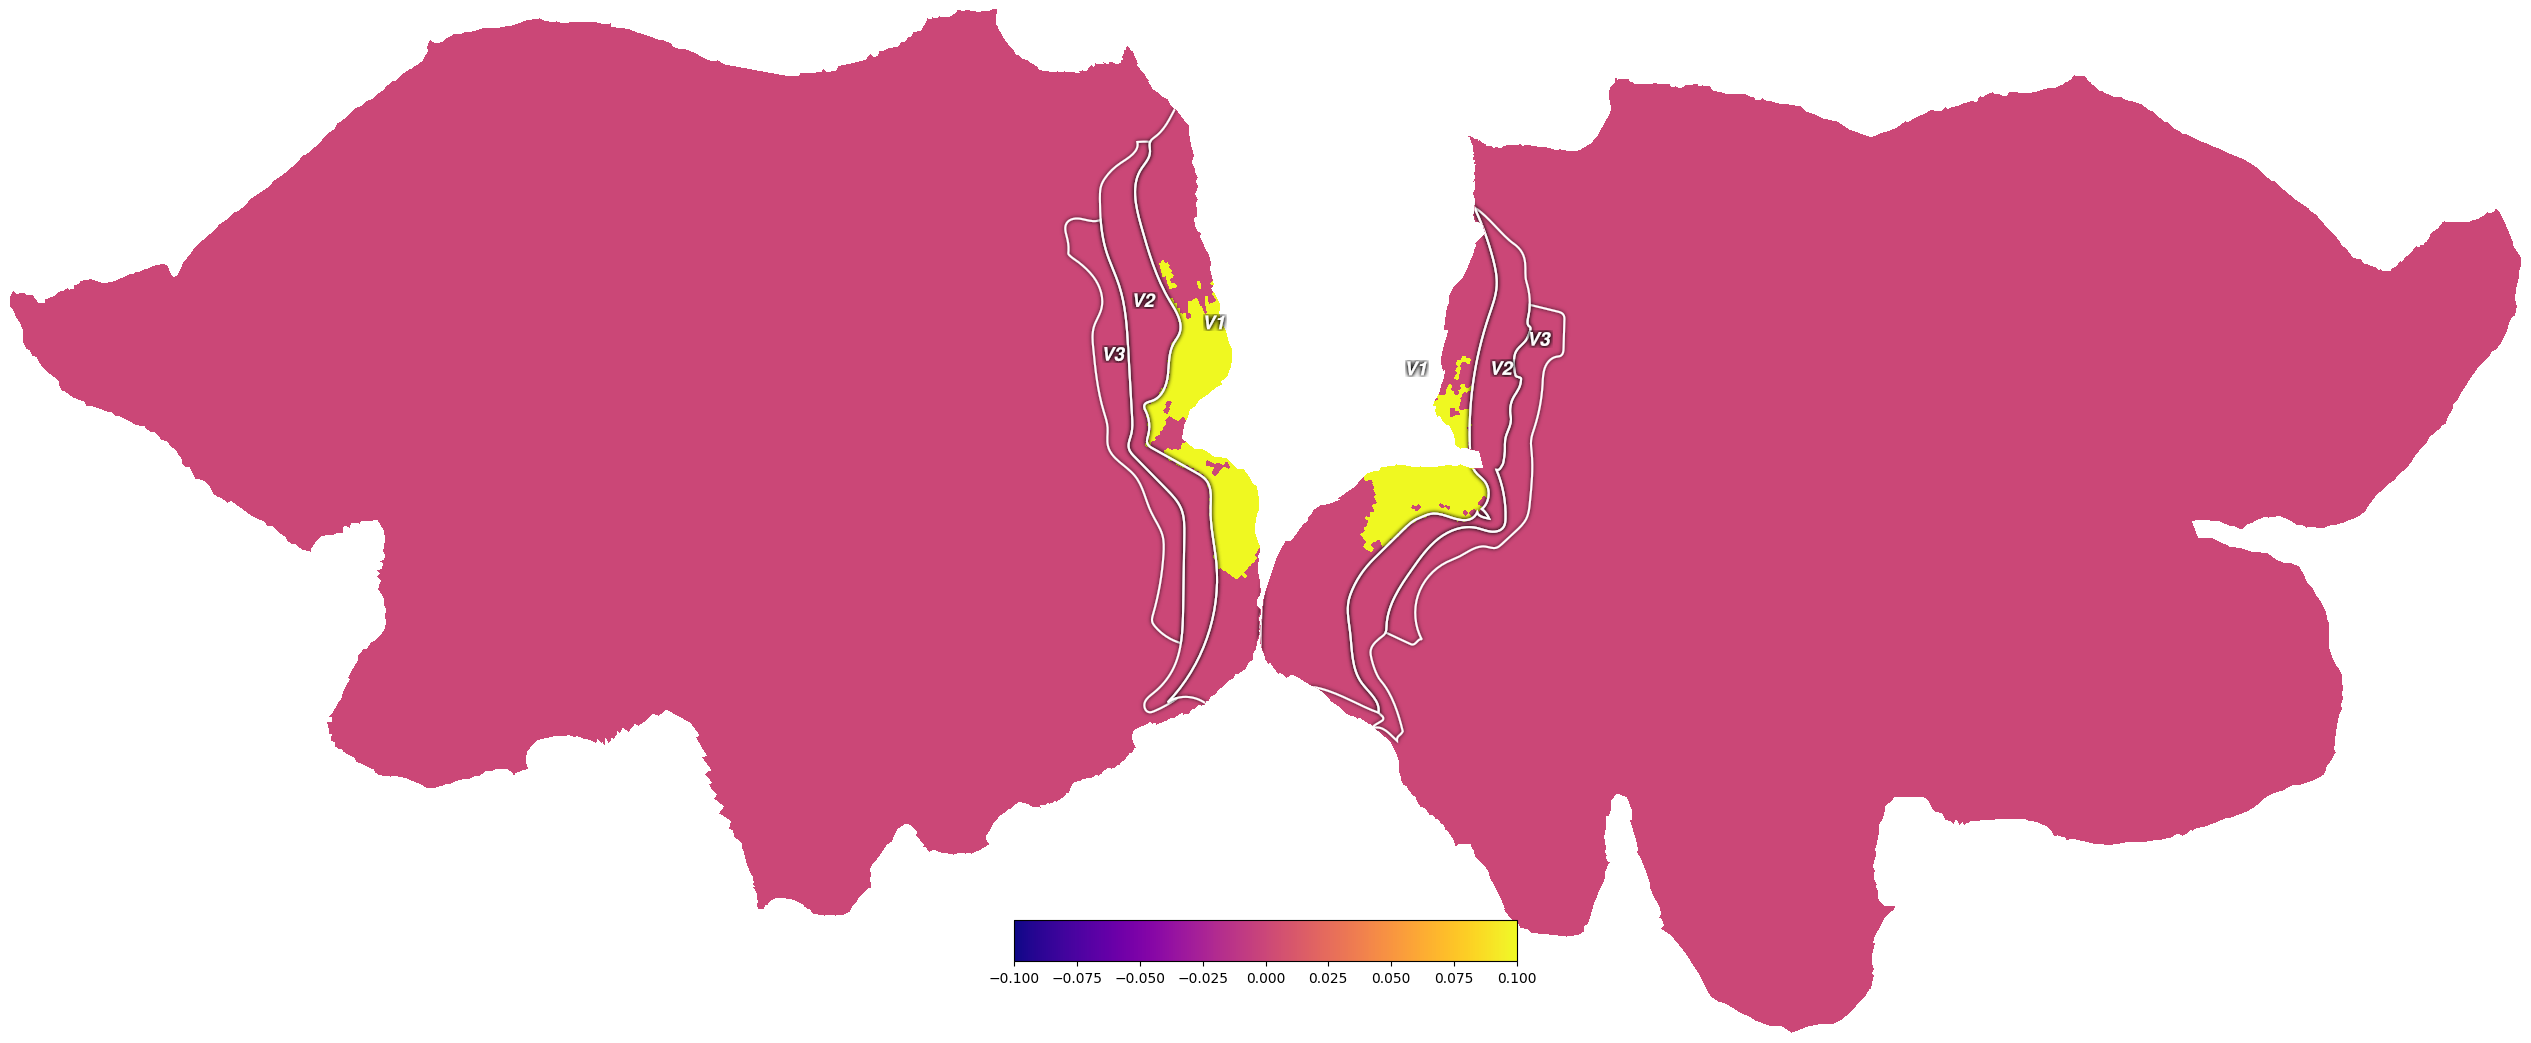

In [9]:
# myv1surf.intmask is a binary mask that shows which vertices we use for CF sampling
cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma'), with_curvature=True);
